In [1]:
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer
import random

random.seed = 123
MAX_GAMES_DEFAULT = 20_000

DEBUG = False

env = TictactoeEnv()
Turns = np.array(['X','O'])

# Question 1
In this section, you will study whether Q-learning can learn to play Tic Tac Toe by playing against
Opt(eps_opt) for some eps_opt ∈ [0, 1]. To do so, implement the Q-learning algorithm. To check the algorithm,
run a Q-learning agent, with a fixed and arbitrary eps ∈ [0, 1), against Opt(0.5) for 20’000 games – switch
the 1st player after every game.
Question 1. Plot average reward for every 250 games during training – i.e. after the 50th game, plot
the average reward of the first 250 games, after the 100th game, plot the average reward of games 51 to
100, etc. Does the agent learn to play Tic Tac Toe?
Expected answer: A figure of average reward over time (caption length < 50 words). Specify your choice
of eps.

In [2]:
def grid_to_string(bts, is_buffer = True):
    _grid = np.reshape(np.frombuffer(bts),(3,3)) if is_buffer else bts
    str_rep = ''
    value2player = {0: '-', 1: 'X', -1: 'O'}
    for i in range(3):
        str_rep +='|'
        for j in range(3):
            str_rep += value2player[int(_grid[i,j])] + (' ' if j<2 else '')
        str_rep+='|\n'
    str_rep+='\n'
    return str_rep

def print_Q_val_with_moves(q_vals, descending=False, only_vals = None):
    qv_temp = {grid_to_string(k): q_vals[k] for k in q_vals if any(map(lambda a: q_vals[k][a] != 0, q_vals[k]))}.items()
    count_free_squares = lambda grid: sum([x=='-' for x in grid])
    if only_vals is not None:
        qv_temp = list(filter(lambda k: count_free_squares(k[0]) == only_vals,qv_temp))
    for (i,j) in sorted(qv_temp, key=lambda k: count_free_squares(k[0]), reverse=descending):
        print(i,j)

In [3]:
import random

# desparate debugging
_epsilons = []
def get_empty_positions_from_grid(_grid):
    '''return all empty positions'''
    avail = []
    for i in range(9):
        pos = (int(i/3), i % 3)
        if _grid[pos] == 0:
            avail.append(pos)
    return avail

class BasePlayer:
    def get_empty_positions(self, _grid):
        return get_empty_positions_from_grid(_grid)

    def hash_grid(self, _grid: np.ndarray):
        return _grid.tobytes()

class QLearntPlayer(BasePlayer):
    def __init__(self, _epsilon: float, _discount_rate_gamma = 0.99, _learning_rate_alpha = 0.05):
        super()
        self._epsilon = _epsilon
        self._discount_rate_gamma = _discount_rate_gamma
        self._learning_rate_alpha = _learning_rate_alpha
        self._Q_values = {}
        self._curr_grid = None
        self._curr_move = None
        self._player = None # 'X' or 'O'

    def prepare_new_game_(self, _player):
        self._curr_grid = None
        self._curr_move = None
        assert _player == 'X' or _player == 'O'
        self._player = _player
        return self

    def get_max_val_action(self, _possible_moves, _grid_hash):
        if len(_possible_moves) == 0:
            q_val = self._Q_values[_grid_hash]['']
            assert type(q_val) is int
            return ''
        # Shuffle moves to prevent bias towards choosing the first thing in the list
        # This is important especially at the beginning when all the q-vals are 0
        # And we are therefore biased towards choosing the first avaliable move, e.g. (0,0) in the
        # starting position
        random.shuffle(_possible_moves)
        return max(_possible_moves, key=self._Q_values[_grid_hash].get)

    def init_q_values_(self, _grid_hash, _possible_moves):
        if _grid_hash not in self._Q_values:
            self._Q_values[_grid_hash] = {} if len(_possible_moves) > 0 else {'': 0}
        for mv in _possible_moves:
            if mv not in self._Q_values[_grid_hash]: self._Q_values[_grid_hash][mv] = 0

    def choose_move_(self, _grid):
        grid_hash = self.hash_grid(_grid)
        # Get moves
        possible_moves = self.get_empty_positions(_grid)
        assert len(possible_moves) > 0
        # Init Q_values
        self.init_q_values_(grid_hash, possible_moves)
        # Choose move (eps.greedy)
        random_sample = random.random()
        play_best_move = random_sample >= self._epsilon
        if play_best_move:
            chosen_move = self.get_max_val_action(possible_moves, grid_hash)
        else:
            chosen_move = random.choice(possible_moves)
        self._curr_grid = _grid
        self._curr_move = chosen_move
        if DEBUG:
            print('-----------------------------------')
            print('Current position: ', '\n' + grid_to_string(_grid, False))
            print('Current Q-vals', self._Q_values[grid_hash])
            print('Random sample ', random_sample, ' _epsilon ', self._epsilon, ' hence I chose ', \
                '*best*' if play_best_move else '*random*', ' move: ', chosen_move )
            print('-----------------------------------')

        return chosen_move

    def update_q_values_(self, new_grid, game_over, _reward):
        """
        update Q values by Q-learning formula.

        new_grid ~ S' in the formula
        """
        prev_move, prev_grid = self._curr_move, self._curr_grid
        self._curr_grid, self._curr_move = None, ''
        new_grid_hash = self.hash_grid(new_grid)
        prev_grid_hash = self.hash_grid(prev_grid)
        # Get max_a (Q(S', a))
        possible_moves_s_dash = [] if game_over else self.get_empty_positions(new_grid)
        self.init_q_values_(new_grid_hash, possible_moves_s_dash)
        max_val_action = self.get_max_val_action(possible_moves_s_dash, new_grid_hash)
        max_q_value = self._Q_values[new_grid_hash][max_val_action]

        if DEBUG:
            print('*** UPDATING Q VALS ****')
            game_over and print('*Game is over*')
            print('Prev_grid: ', '\n' + grid_to_string(prev_grid, False))
            print('Prev_move: ', prev_move)
            print('new_grid: ', '\n' + grid_to_string(new_grid, False))
            print('max_val_action: ', max_val_action)
            print('Q-vals before: ', self._Q_values[prev_grid_hash])

        # Update according to Q-learning formula
        prev_q_val = self._Q_values[prev_grid_hash][prev_move]
        self._Q_values[prev_grid_hash][prev_move] += self._learning_rate_alpha*(_reward + self._discount_rate_gamma*max_q_value - prev_q_val)
        if DEBUG:
            print('_reward: ', _reward, 'max-q-val', max_q_value, 'discount', self._discount_rate_gamma,\
                'self._learning_rate_alpha',self._learning_rate_alpha)
            print('Q-vals after: ', self._Q_values[prev_grid_hash])
            print('*****')

In [4]:
def run_n_games_against_opt(_max_games_number, _our_player, _opponent_epsilon, _our_player_new_game_epsilon, _update_q_values, _progress_print=None, _throw_error_on_illegal_moves = True):
    _rewards = [None for _ in range(_max_games_number)]
    _turns = ['X','O']
    opponent =  OptimalPlayer(epsilon=_opponent_epsilon, player=_turns[0])

    for game in range(_max_games_number):
        env.reset()
        _current_grid, _, __ = env.observe()
        _turns = _turns[::-1] # Reverse after every game to ensure both sides played equally
        opponent.player = _turns[0]
        _our_player = _our_player.prepare_new_game_(_turns[1])
        assert opponent.player != _our_player._player
        _our_player._epsilon = _our_player_new_game_epsilon(game_number_n=game)
        # epsilons[-1].append(_our_player._epsilon)

        if (_progress_print and game % _progress_print == 0) or DEBUG:
            print('Game ', game, ' begins.')
            if DEBUG:
                print('We play: ', _our_player._player)
                input('awaiting input: ')

        for turn in range(9):
            opponent_turn = env.current_player == opponent.player
            if opponent_turn:
                chosen_move = opponent.act(_current_grid)
            else:
                chosen_move = _our_player.choose_move_(_current_grid)

            # This if branch was added to make this work for DQN player. If this breaks for normal player
            # it is likely because of it (JL, May 6 2022)
            if (not _throw_error_on_illegal_moves) and (chosen_move not in get_empty_positions_from_grid(_current_grid)):
                _current_grid = None
                _end = True
                _reward = -1 # You lose if you play an illegal move

            else:
                _current_grid, _end, winner = env.step(chosen_move, print_grid=False)
                _reward = env.reward(_our_player._player)

            ## This was also altered to make this work for DQN player  (JL, May 6 2022)
            if _update_q_values and (opponent_turn and turn > 0 or _end):
                _our_player.update_q_values_(_current_grid, game_over=_end, _reward=_reward)
            if _end:
                _rewards[game] = _reward
                break
    return _rewards

Game  0  begins.
Game  2500  begins.
Game  5000  begins.
Game  7500  begins.
Game  10000  begins.
Game  12500  begins.
Game  15000  begins.
Game  17500  begins.
Our agent won 9179 times


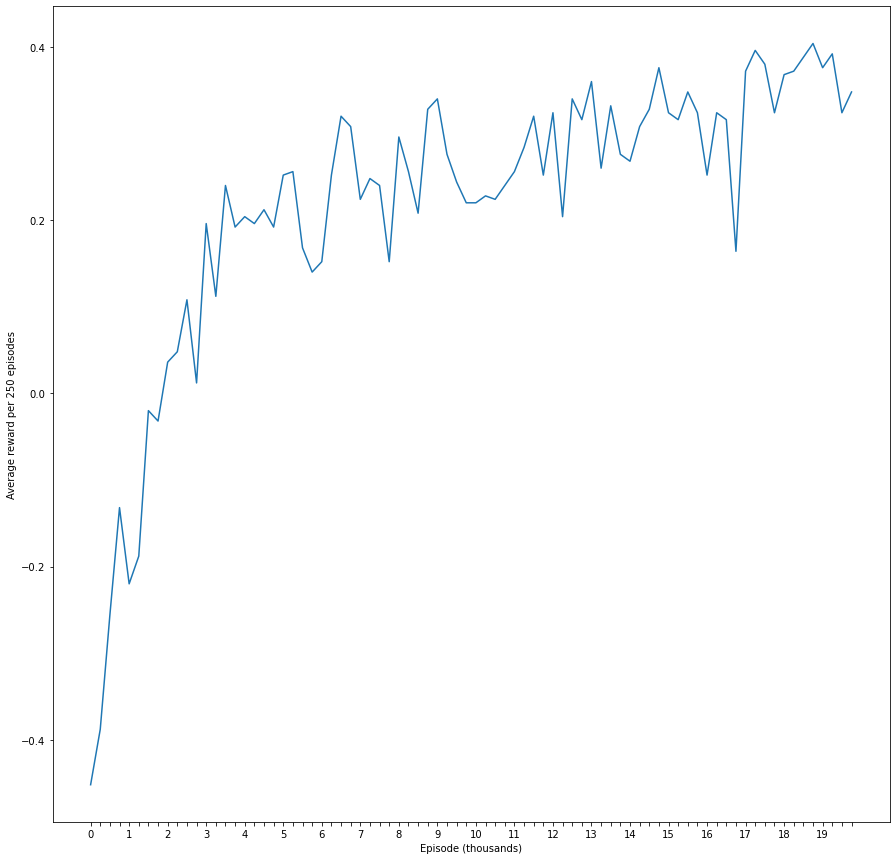

In [5]:
import matplotlib.pyplot as plt

q1_epsilon = 0.1 # Chosen because they use this in Q2 so this will allow us to nicely compare

q1_max_games = MAX_GAMES_DEFAULT
q1_q_learnt_player = QLearntPlayer(_epsilon=q1_epsilon)
print_Q_val_with_moves(q1_q_learnt_player._Q_values)
q1_avgs = []
q1_rewards = []
q1_total_wins = 0

for game_epoch in range(q1_max_games//250):
    if game_epoch % 10 == 0:
        print('Game ', game_epoch*250, ' begins.')
    run_rewards = run_n_games_against_opt(_max_games_number=250, _our_player=q1_q_learnt_player, _opponent_epsilon=0.5, \
            _our_player_new_game_epsilon=lambda game_number_n: q1_epsilon, _update_q_values=True)
    q1_rewards+=run_rewards
    q1_avgs.append(np.average(run_rewards))
    q1_total_wins += sum(1 if rew ==1 else 0 for rew in run_rewards)

print('Our agent won {} times'.format(q1_total_wins))
plt.figure(figsize=(15,15))
ax = plt.plot(q1_avgs)
plt.xticks(ticks=range(len(q1_avgs)), labels=[str(x*250 // 1000) if x*250 % 1000 == 0 else '' for x in range(len(q1_avgs))])
plt.ylabel('Average reward per 250 episodes')
plt.xlabel('Episode (thousands)')
plt.show()

In [6]:
_qv = q1_q_learnt_player._Q_values
print_Q_val_with_moves(_qv)

|O X O|
|O O X|
|- X X|

 {(2, 0): 0.05}
|X O O|
|O O X|
|X X -|

 {(2, 2): 0.5123250208844702}
|X O O|
|O X O|
|X X -|

 {(2, 2): 0.05}
|O X O|
|X X -|
|O O X|

 {(1, 2): 0.0975}
|- X X|
|O X O|
|O O X|

 {(0, 0): 0.05}
|X O X|
|O O -|
|O X X|

 {(1, 2): 0.7853612360570624}
|O O X|
|X O O|
|- X X|

 {(2, 0): 0.8251753852762027}
|O O X|
|X O -|
|O X X|

 {(1, 2): 0.8714878434348967}
|- X O|
|X O O|
|X O X|

 {(0, 0): 0.05}
|O X O|
|O O X|
|X - X|

 {(2, 1): 0.05}
|O X X|
|X O -|
|O O X|

 {(1, 2): 0.142625}
|O O X|
|X O O|
|X - X|

 {(2, 1): 0.2262190625}
|X - X|
|X O O|
|O X O|

 {(0, 1): 0.43119990772354005}
|X X O|
|O - O|
|X O X|

 {(1, 1): 0.05}
|O O -|
|X X O|
|X X O|

 {(0, 2): 0.18549375}
|O X O|
|- X X|
|O O X|

 {(1, 0): 0.142625}
|O X X|
|O - X|
|X O O|

 {(1, 1): 0.05}
|O O X|
|X - O|
|X X O|

 {(1, 1): 0.0975}
|X O X|
|O X O|
|- X O|

 {(2, 0): 0.18549375}
|O O -|
|O X X|
|X X O|

 {(0, 2): 0.36975059027539064}
|O O X|
|X O O|
|X X -|

 {(2, 2): 0.0975}
|O X O|
|- X X|
|X 

In [7]:
print_Q_val_with_moves(_qv, descending=True)

|- - -|
|- - -|
|- - -|

 {(0, 0): 0.008237972913945648, (0, 1): 0.08608215545211176, (0, 2): 0.061208678248183906, (1, 0): 0.0035775273085872487, (1, 1): 0.0013018023529861747, (1, 2): 0.0039008171057559687, (2, 0): 0.1304944515498322, (2, 1): 0.5611184003505364, (2, 2): 0.23932449183909754}
|- - -|
|- - -|
|X - -|

 {(0, 0): -0.0026241780717027427, (0, 1): 0.00048521698202447076, (0, 2): 0.02422599679915936, (1, 0): 0.0, (1, 1): 0.0004540599202023458, (1, 2): -0.0008953088260989548, (2, 1): -0.0035033104008979315, (2, 2): 0.2714509791284224}
|- - X|
|- - -|
|- - -|

 {(0, 0): 0.3046675471589879, (0, 1): -0.00201547659971291, (1, 0): 0.0019536103130291336, (1, 1): 2.5811390286912876e-05, (1, 2): -0.0034465528194789433, (2, 0): 0.03999623040619364, (2, 1): 0.0008403911354602136, (2, 2): 0.03427186877579748}
|X - -|
|- - -|
|- - -|

 {(0, 1): -0.002761847141437286, (0, 2): 0.005729805893559219, (1, 0): -0.0005501659023328634, (1, 1): 0.0011967155353291889, (1, 2): -0.0009032640625387232

In [8]:
print_Q_val_with_moves(_qv, only_vals=3)

|- X X|
|- O O|
|O - X|

 {(0, 0): 0.05, (1, 0): 0, (2, 1): -0.05}
|- O X|
|O - -|
|X O X|

 {(0, 0): 0, (1, 1): 0.05, (1, 2): 0}
|X - -|
|O O X|
|- X O|

 {(0, 1): 0.018939249276073246, (0, 2): 0, (2, 0): 0.0}
|X - O|
|O O -|
|X X -|

 {(0, 1): -0.05, (1, 2): 0.06222227918764423, (2, 2): 0}
|- O -|
|O X -|
|O X X|

 {(0, 0): 0.3365795687109375, (0, 2): 0, (1, 2): -0.05}
|O O -|
|O X -|
|X - X|

 {(0, 2): 0, (1, 2): -0.05, (2, 1): 0}
|O - X|
|X O O|
|X - -|

 {(0, 1): -0.05, (2, 1): -0.05, (2, 2): 0.013766878125000001}
|X O -|
|X O -|
|O X -|

 {(0, 2): 0.0, (1, 2): -0.05, (2, 2): 0}
|O O -|
|X X -|
|O X -|

 {(0, 2): 0, (1, 2): 0.0975, (2, 2): 0}
|X O -|
|O X -|
|X - O|

 {(0, 2): 0.05, (1, 2): 0, (2, 1): 0}
|- - -|
|O X X|
|O X O|

 {(0, 0): 0, (0, 1): 0, (0, 2): -0.05}
|X - -|
|O O X|
|X - O|

 {(0, 1): 0.006053013914062501, (0, 2): 0.0, (2, 1): 0}
|O - X|
|- X -|
|O O X|

 {(0, 1): 0, (1, 0): 0, (1, 2): 0.05}
|- X O|
|- O -|
|X X O|

 {(0, 0): -0.142625, (1, 0): -0.142625, (1, 2): 

# Question 2. 
#### Plot average reward for every 250 games during training. Does decreasing epsilon help training compared to having a fixed epsilon? What is the effect of n∗?
Expected answer: A figure showing average reward over time for different values of n∗ (caption length < 200 words)

Current n_star_q2 = 1.0
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
Current n_star_q2 = 14.142135623730951
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
Current n_star_q2 = 200.00000000000003
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
Current n_star_q2 = 2828.4271247461907
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
Current n_star_q2 = 40000.0
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
won games per agent {1.0: 8870, 14.142135623730951: 9360, 200.00000000000003: 9890, 2828.4271247461907: 9488, 40000.0: 5556}


Text(0, 0.5, 'Average q2_rewards per 250 epochs')

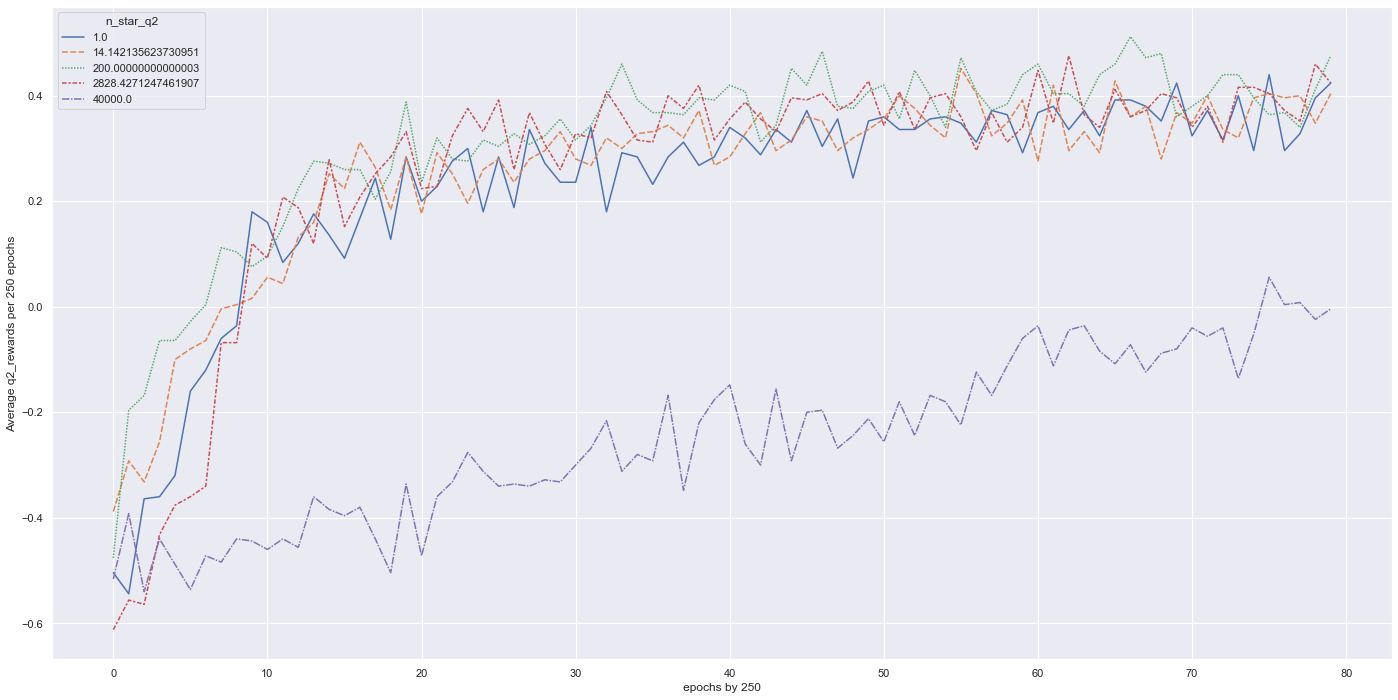

In [9]:
q2_max_games = MAX_GAMES_DEFAULT
q2_n_stars =  np.geomspace(1, 40000, num=5) # Includes 1 and 40000
q2_epoch_size = 250
q2_rewards = {n_star_q2: [] for n_star_q2 in q2_n_stars}
q2_avgs = {n_star_q2: [] for n_star_q2 in q2_n_stars}
q2_M_opt = {n_star_q2: [] for n_star_q2 in q2_n_stars}
q2_M_rand = {n_star_q2: [] for n_star_q2 in q2_n_stars}
q2_total_wins = {n_star_q2: 0 for n_star_q2 in q2_n_stars}

q2_players = {}

q2_min_epsilon = 0.1
q2_max_epsilon = 0.8
def q2_calc_epsilon_factory(n_star_q2, epoch_size, game_epoch):
        def _calc_epsilon(game_number_n):
            real_game_number = game_epoch*q2_epoch_size + game_number_n
            return max(q2_min_epsilon, q2_max_epsilon*(1-(real_game_number/n_star_q2)))
        return _calc_epsilon

for n_star_q2 in q2_n_stars:
    # epsilons.append([])
    q2_starting_epsilon  = q2_calc_epsilon_factory(n_star_q2, q2_epoch_size, 0)(0)
    q2_q_learnt_player = QLearntPlayer(_epsilon=q2_starting_epsilon)
    q2_players[n_star_q2] = q2_q_learnt_player
    print('Current n_star_q2 = {}'.format(n_star_q2))

    for game_epoch in range(q2_max_games//q2_epoch_size):
        q2_calc_epsilon = q2_calc_epsilon_factory(n_star_q2=n_star_q2, epoch_size=q2_epoch_size, game_epoch=game_epoch)
        # print(game_epoch, q2_q_learnt_player._epsilon)
        if game_epoch % 20 == 0:
            print('Game ', game_epoch*q2_epoch_size, ' begins.')

        # Run 250 games with updating Q-vals and observe reward (exec 2)
        q2_run_rewards = run_n_games_against_opt(_max_games_number=q2_epoch_size, _our_player=q2_q_learnt_player, _opponent_epsilon=0.5, \
            _our_player_new_game_epsilon=q2_calc_epsilon, _update_q_values=True)
        q2_avgs[n_star_q2].append(np.average(q2_run_rewards))
        q2_rewards[n_star_q2] += q2_run_rewards
        q2_total_wins[n_star_q2] += sum(1 if rew ==1 else 0 for rew in q2_run_rewards)

        # Run 500 games for M_opt calculation
        q2_M_opt_rewards = run_n_games_against_opt(_max_games_number=500, _our_player=q2_q_learnt_player, _opponent_epsilon=0, \
            _our_player_new_game_epsilon=lambda game_number_n: 0, _update_q_values=False)
        q2_M_opt[n_star_q2].append(np.average(q2_M_opt_rewards))


        # Run 500 games for M_rand calculation
        M_rand_rewards = run_n_games_against_opt(_max_games_number=500, _our_player=q2_q_learnt_player, _opponent_epsilon=1, \
            _our_player_new_game_epsilon=lambda game_number_n: 0, _update_q_values=False)
        q2_M_rand[n_star_q2].append(np.average(M_rand_rewards))

print('won games per agent', q2_total_wins)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# avgs = {n_star_q2: [] for n_star_q2 in q2_n_stars}
# for x in range(0,q2_max_games, 250):
#     lower_index = x
#     upper_index = min(x+250, q2_max_games-1)
#     for n_star_q2 in q2_n_stars:
#         slice = q2_rewards[n_star_q2][lower_index:upper_index]
#         avgs[n_star_q2].append(sum(slice)/len(slice))

q2_data = pd.DataFrame(q2_avgs)
q2_data.index.name = 'epochs by 250'
q2_data.transpose().index.name = 'n_star_q2'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=q2_data)
g.set_ylabel('Average q2_rewards per 250 epochs')

# plt.figure(figsize=(15,15))
# ax = plt.plot(q2_avgs)
# plt.xticks(ticks=range(len(q2_avgs)), labels=[str(x*250 // 1000) if x*250 % 1000 == 0 else '' for x in range(len(avgs))])
# plt.ylabel('Average reward per 250 episodes')
# plt.xlabel('Episode (thousands)')
# plt.show()


In [10]:
q2_players[1.0]

In [11]:
pl = list(q2_players.values())

In [12]:
# DELETE

# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# avgs = {n_star: [] for n_star in n_stars}
# for x in range(0,max_games, 250):
#     lower_index = x
#     upper_index = min(x+250, max_games-1)
#     for n_star in n_stars:
#         slice = rewards[n_star][lower_index:upper_index]
#         avgs[n_star].append(sum(slice)/len(slice))

# q2_data = pd.DataFrame(avgs)
# q2_data.index.name = 'epochs by 250'
# q2_data.transpose().index.name = 'n_star'
# sns.set(rc={'figure.figsize':(24,12)})
# g = sns.lineplot(data=q2_data)
# g.set_ylabel('Average rewards per 250 epochs')

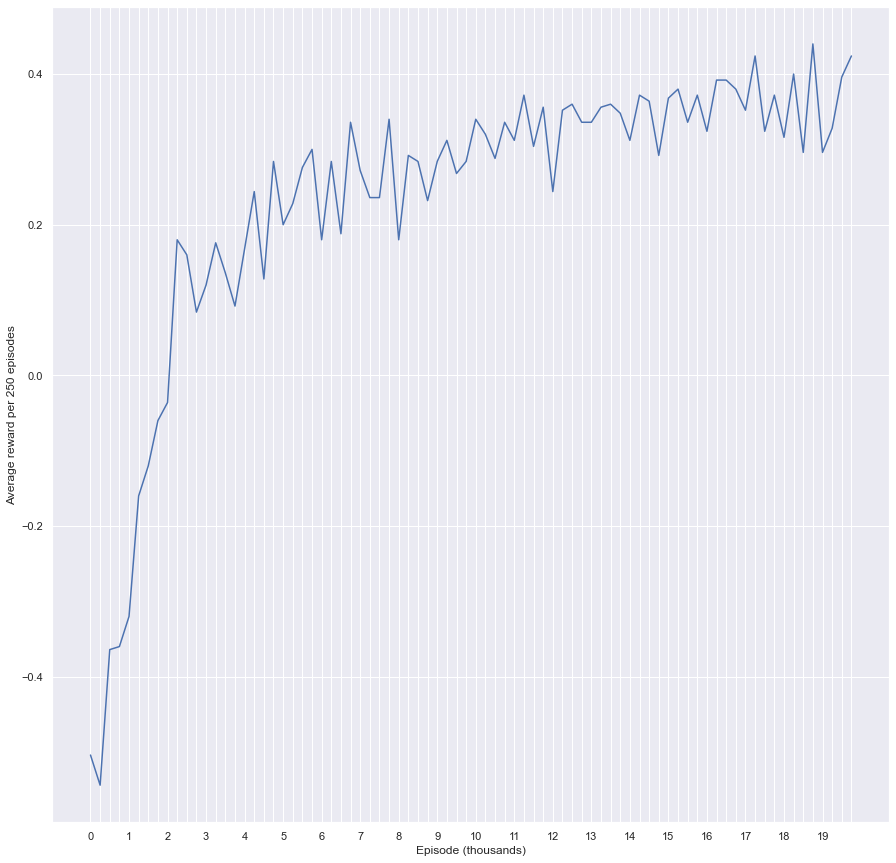

In [13]:
# Print the same plot as in exe 1 to ensure results are the same

plt.figure(figsize=(15,15))
ax = plt.plot(q2_avgs[1.0])
plt.xticks(ticks=range(len(q2_avgs[1.0])), labels=[str(x*250 // 1000) if x*250 % 1000 == 0 else '' for x in range(len(q2_avgs[1.0]))])
plt.ylabel('Average reward per 250 episodes')
plt.xlabel('Episode (thousands)')
plt.show()

In [14]:
for (n_star, rews) in q2_rewards.items():
    print('{} won {} games'.format(n_star, sum(1 if rew ==1 else 0 for rew in rews)))

1.0 won 8870 games
14.142135623730951 won 9360 games
200.00000000000003 won 9890 games
2828.4271247461907 won 9488 games
40000.0 won 5556 games


In [15]:
len(q2_rewards[1.0])

20000

#### Q2
*Does decreasing epsilon help with training compared to fix epsilon?*

Surprisingly, it seems to only help very little. Perhaps this is because the game is relatively simple and has few states and in consequence the minimum epsilon value of $\varepsilon=0$.1 is large enough for enough exploration to happen, but notice that $n^*=1$ (which means virtually no decrease and instead keeping epsilon stable at 0.1 for all games) seems to perform as well as having 14, 200, or almost 3000 exploratory games. 

*What is the effect of n\*?*

The effect seems to be quite limitted: unsurprisingly, if $n^*=40000$, the algorithm performs very poorly. This makes sense, because such algorithms plays the 20000th game with $\varepsilon= (1- \frac{20000}{40000})*0.8 = 0.4$, i.e. it plays 40% of the moves randomly in the last game (and even more before). All the other values converge to eps = 0.1 by the end of the simulation and they are thus more comparable. It seems that the difference between the remaining algorithms is very small: indeed, perhaps $n^*=2828$ performs best, it seems to be most consistently on top and it wins most games overall (9850 as opposed to 9583 won by $\varepsilon=200$), but the graph is very noisy and it is hard to tell if this difference is entirely due to better training which explores more or if it is largely just an artifact of the noise.

Text(0, 0.5, 'M_opt')

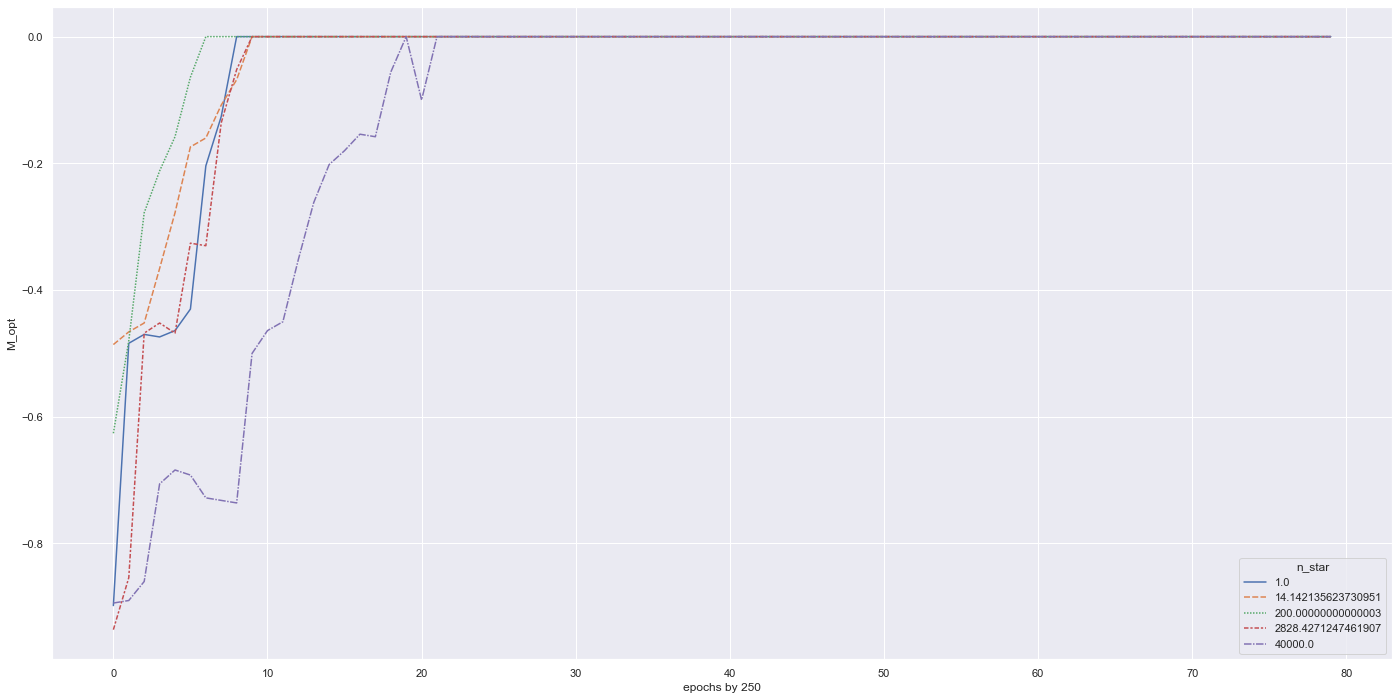

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

q2_M_opt_df = pd.DataFrame(q2_M_opt)
q2_M_opt_df.index.name = 'epochs by 250'
q2_M_opt_df.transpose().index.name = 'n_star'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=q2_M_opt_df)
g.set_ylabel('M_opt')

Text(0, 0.5, 'q2_M_rand')

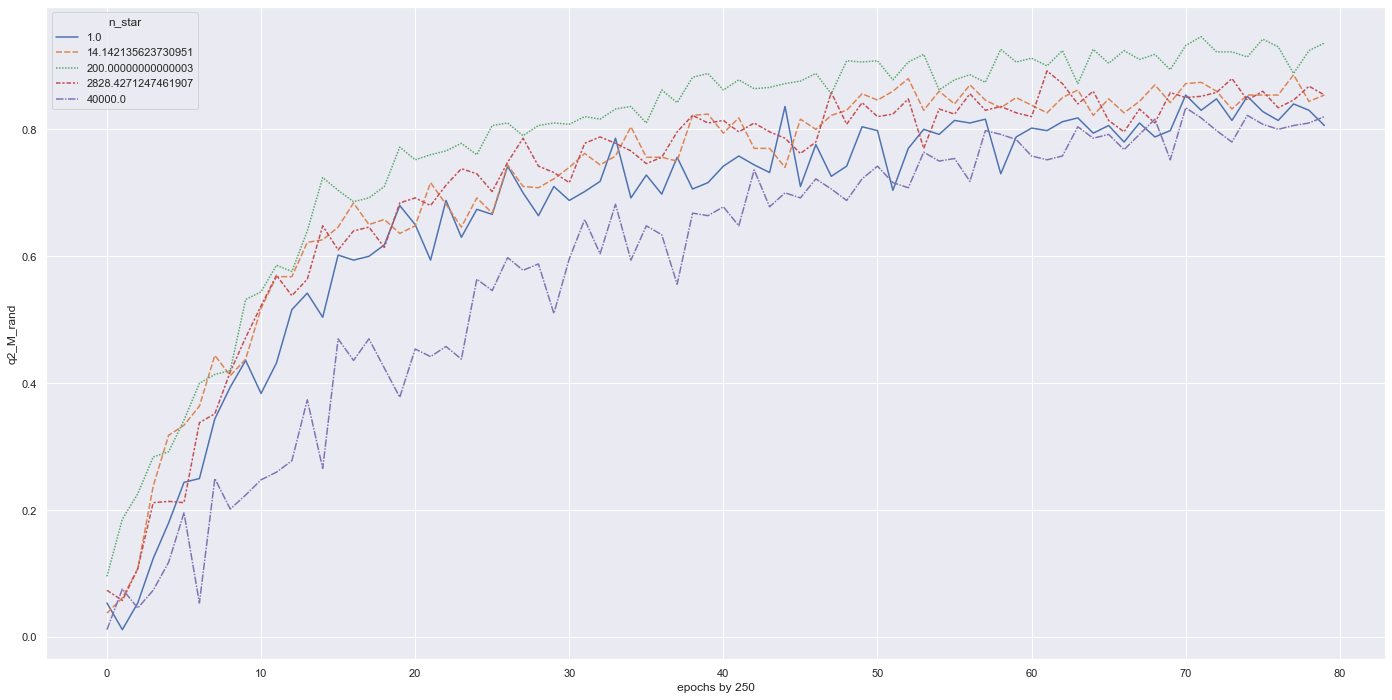

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

q2_M_rand_df = pd.DataFrame(q2_M_rand)
q2_M_rand_df.index.name = 'epochs by 250'
q2_M_rand_df.transpose().index.name = 'n_star'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=q2_M_rand_df)
g.set_ylabel('q2_M_rand')

#### Q3
*Describe the differences and similarities between the curves and the one in the previous question*

Here we can see all values of $n^*$ quickly reach almost optimal performance against the optimal player. This is perhaps because often one good move can ruin an opponent's winning chances. It takes much longer to achieve optimal play against a random oponent, perhaps because again, we need to play all moves perfectly to win, but only 1 correct move can prevent failure and thus it is easier to learn to defend and not-lose against a good player than to beat a poor one. Here we again see the $n^*=40000$ player performing rather poorly just like we did in the previous exercise, but the gap is not as large as before. The best performing player is again $n^*=2828$ but we can see the data is again noisy with $n^*=1$ or $n^*=200$ performing best in some sets of 250 epochs. **TODO: It is a bit weird we perform so well against M_opt from the beginning, perhaps we should investigate this if there is a bug (I dont see where there could be but the result is suspicious)**

# Q4
Choose the best value of $n^∗$ that you found in the previous section. Run Q-learning against Opt($\epsilon_{opt}$) for
different values of $\epsilon_{opt}$ for 20’000 games – switch the 1st player after every game. Choose several values
of $\epsilon_{opt}$ from a reasonably wide interval between 0 to 1 – particularly, include $\epsilon_{opt}$ = 0.


Question 4. After every 250 games during training, compute the ‘test’ $M_{opt}$ and $M_{rand}$ for your agents
– for each value of $\epsilon_{opt}$. Plot $M_{opt}$ and $M_{rand}$ over time. What do you observe? How can you explain it?
Expected answer: A figure showing $M_{opt}$ and $M_{rand}$ over time for different values of $\epsilon_{opt}$ (caption length
< 250 words).

In [18]:
best_n_star = 2828.427

In [19]:
q4_max_games = MAX_GAMES_DEFAULT
q4_epoch_size = 250

q4_eps_opts = np.linspace(0,1,num=5)

q4_rewards_eps = {eps_opt: [] for eps_opt in q4_eps_opts}
q4_M_opt_eps = {eps_opt: [] for eps_opt in q4_eps_opts}
q4_M_rand_eps = {eps_opt: [] for eps_opt in q4_eps_opts}

q4_min_epsilon = 0.1
q4_max_epsilon = 0.8


def q4_calc_epsilon_factory_eps(epoch_size, game_epoch):
        def _calc_epsilon(game_number_n):
            real_game_number = game_epoch*epoch_size + game_number_n
            return max(q4_min_epsilon, q4_max_epsilon*(1-(real_game_number/best_n_star)))
        return _calc_epsilon

for eps_opt in q4_eps_opts:
    q4_starting_epsilon  = q4_calc_epsilon_factory_eps(q4_epoch_size, 0)(0)
    q4_q_learnt_player = QLearntPlayer(_epsilon=q4_starting_epsilon)
    print('Current eps_opt = {}'.format(eps_opt))

    for game_epoch in range(q4_max_games//q4_epoch_size):
        q4_calc_epsilon = q4_calc_epsilon_factory_eps(epoch_size=q4_epoch_size, game_epoch=game_epoch)
        if game_epoch % 20 == 0:
            print('Game ', game_epoch*q4_epoch_size, ' begins.')

        # Run 250 games with updating Q-vals and observe reward (exec 4)
        q4_run_rewards = run_n_games_against_opt(_max_games_number=q4_epoch_size, _our_player=q4_q_learnt_player, _opponent_epsilon=eps_opt, \
            _our_player_new_game_epsilon=q4_calc_epsilon, _update_q_values=True)
        q4_rewards_eps[eps_opt] += q4_run_rewards

        # Run 500 games for q4_M_opt_eps calculation
        q4_M_opt_eps_rewards = run_n_games_against_opt(_max_games_number=500, _our_player=q4_q_learnt_player, _opponent_epsilon=0, \
            _our_player_new_game_epsilon=lambda game_number_n: 0, _update_q_values=False)
        q4_M_opt_eps[eps_opt].append(np.average(q4_M_opt_eps_rewards))


        # Run 500 games for q4_M_rand_eps calculation
        q4_M_rand_eps_rewards = run_n_games_against_opt(_max_games_number=500, _our_player=q4_q_learnt_player, _opponent_epsilon=1, \
            _our_player_new_game_epsilon=lambda game_number_n: 0, _update_q_values=False)
        q4_M_rand_eps[eps_opt].append(np.average(q4_M_rand_eps_rewards))


Current eps_opt = 0.0
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
Current eps_opt = 0.25
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
Current eps_opt = 0.5
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
Current eps_opt = 0.75
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
Current eps_opt = 1.0
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.


Text(0, 0.5, 'M_opt_eps')

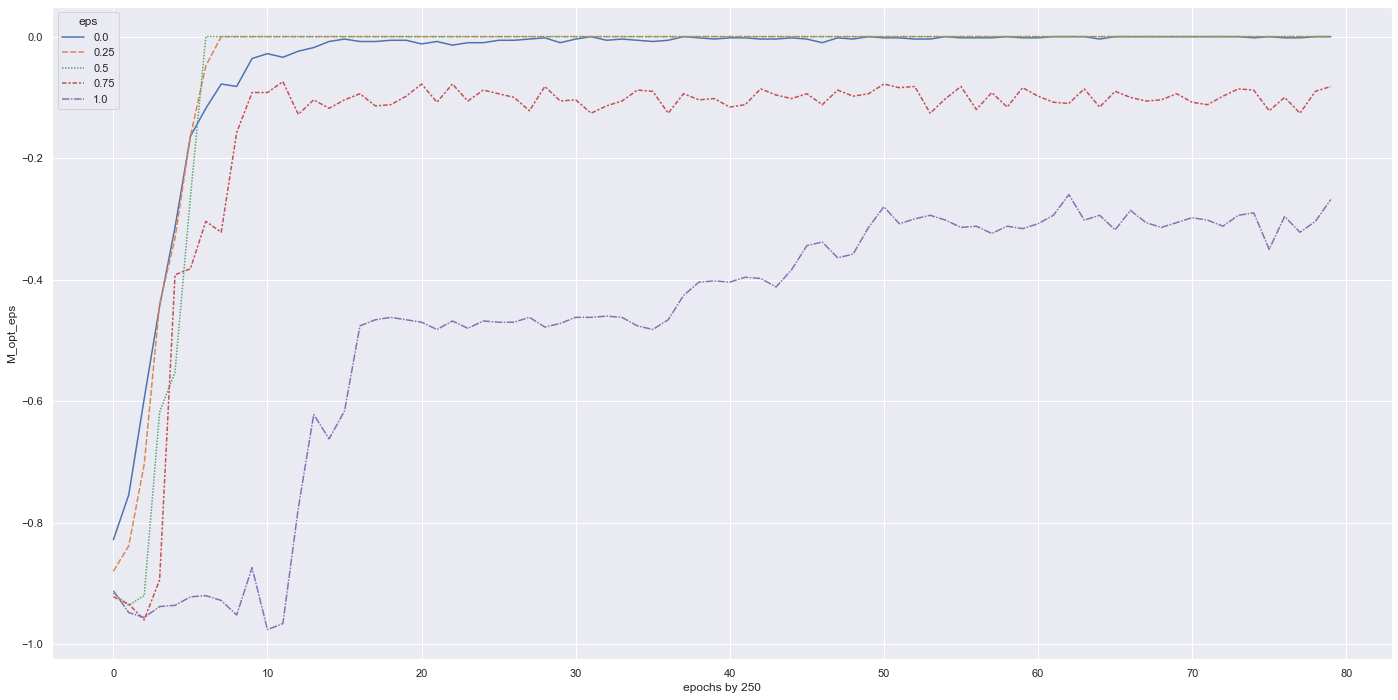

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

q4_M_opt_eps_df = pd.DataFrame(q4_M_opt_eps)
q4_M_opt_eps_df.index.name = 'epochs by 250'
q4_M_opt_eps_df.transpose().index.name = 'eps'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=q4_M_opt_eps_df)
g.set_ylabel('M_opt_eps')

Text(0, 0.5, 'M_rand_eps')

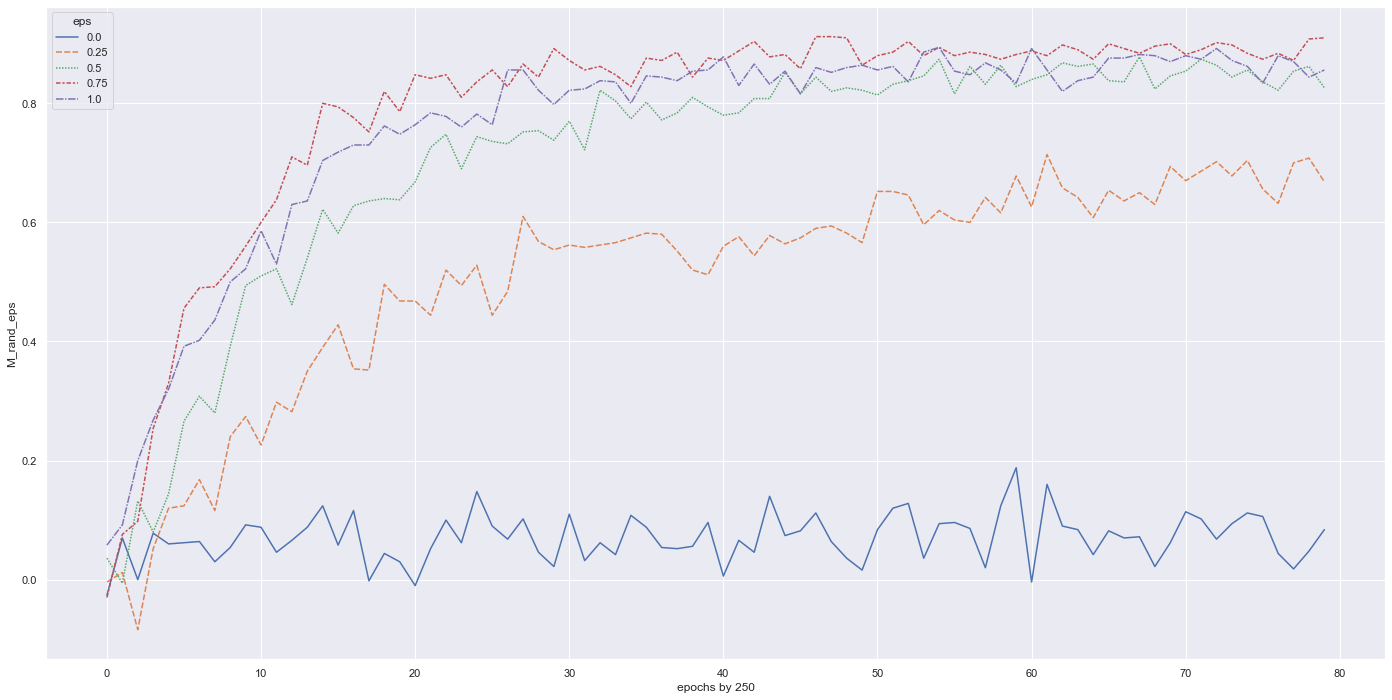

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

q4_M_rand_eps_df = pd.DataFrame(q4_M_rand_eps)
q4_M_rand_eps_df.index.name = 'epochs by 250'
q4_M_rand_eps_df.transpose().index.name = 'eps'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=q4_M_rand_eps_df)
g.set_ylabel('M_rand_eps')

#### Question 4 (answered). 
After every 250 games during training, compute the ‘test’ $M_{opt}$ and $M_{rand}$ for your agents
– for each value of $\epsilon_{opt}$. Plot $M_{opt}$ and $M_{rand}$ over time. What do you observe? How can you explain it?
Expected answer: A figure showing $M_{opt}$ and $M_{rand}$ over time for different values of $\epsilon_{opt}$ (caption length
< 250 words).

The most interesting observation is the discrepancy between performance of $\varepsilon=0$ in M_opt and M_rand (and the same but reversed for $\varepsilon=1$). This is due to the fact that when we play a perfect oponent ($\varepsilon=0$) only, we learn to defend perfectly (hence very good performance in M_opt). However, we never get into winning positions, hence when we are then faced with a random opponent, our performance is only slightly better than 0 as we also play randomly in the winning positions hence our Q-values are 0 for all moves as we have never encountered these positions. It is similar in reverse for ($\varepsilon=1$) which never gets properly punished for going into bad positions and it consequently fails when playing against the optimal opponent.


In [22]:
print('Best M_opt:', q4_M_opt_eps_df.max())
print('\n')
print('Best M_rand', q4_M_rand_eps_df.max())

Best M_opt: eps
0.00    0.000
0.25    0.000
0.50    0.000
0.75   -0.074
1.00   -0.260
dtype: float64


Best M_rand eps
0.00    0.188
0.25    0.714
0.50    0.878
0.75    0.912
1.00    0.894
dtype: float64



# Q5 (answer)
What are the highest values of $M_{opt}$ and $M_{rand}$ that you could achieve after playing 20’000 games?

The highest value of $M_{opt}$ is achieved by all $\varepsilon$, except $\varepsilon=1$ and it is the value 0 which is the best that we can hope for against  $M_{opt}$. The highest value of $M_{rand}$ is near $0.910$ achieved by  $\varepsilon=0.75$ 

# Q6 (answer)
*Question 6. (Theory) Assume that Agent 1 learns by playing against $\text{Opt}(0)$ and find the optimal Q-
values $Q_1(s, a)$. In addition, assume that Agent 2 learns by playing against $\text{Opt}(1)$ and find the optimal
Q-values $Q_2(s, a)$. Do $Q_1(s, a)$ and $Q_2(s, a)$ have the same values? Justify your answer. (answer length
< 150 words)*

No, they will not have the same values. This is because if we play an optimal agent, we will never win and thus never observe a positive reward. Therefore all Q-values will be at best 0. However, playing against a random oponent, we will definitely win sometimes and as we will get closer and closer to convergence, we will play better and better and win more and more. We will therefore definitely observe positive rewards at times. Hence, the Q-values will be different.

# 2.2 Learning by practice
In this section, your are supposed to ask whether Q-learning can learn to play Tic Tac Toe by only
playing against itself. For different values of $\epsilon \in [0, 1)$, run a Q-learning agent against itself for 20’000
games – i.e. both players use the same set of Q-values and update the same set of Q-values.



# Q7 (code below)
*Question 7. After every 250 games during training, compute the ‘test’ $M_{opt}$ and $M_{rand}$ for different
values of $\epsilon \in [0, 1)$. Does the agent learn to play Tic Tac Toe? What is the effect of $\epsilon$?
Expected answer: A figure showing $M_{opt}$ and $M_{rand}$ over time for different values of $\epsilon \in [0, 1)$ (caption
length < 100 words).*

In [23]:
def run_n_games_against_self(_max_games_number, _our_player, _our_player_new_game_epsilon, _update_q_values, _progress_print=None, _throw_error_on_illegal_moves = True):
    _rewards = {'our_player': [None for _ in range(_max_games_number)],'opponent': [None for _ in range(_max_games_number)]}
    _turns = ['X','O']
    if isinstance(_our_player,QLearntPlayer):
        # Added this branch to make this work for DQN also. 
        opponent = QLearntPlayer(_our_player._epsilon,_our_player._discount_rate_gamma, _our_player._learning_rate_alpha)

        # Ensure they share Q_values... I think this should just work
        opponent._Q_values = _our_player._Q_values

    # ! TODO: Make this also work for DQN_Player
    # if isinstance(_our_player, DQN_Player):
        # ! Init DQN opponent here.
        # ! THere are problems with defining this function this way as when it runs,
        # DQN player is not yet defined. Perhaps these two branches could be unified, but I leave this to
        # you Alex:)
        # raise NotImplementedError


    for game in range(_max_games_number):
        if _progress_print and game % _progress_print == 0:
            print('Game ', game, ' begins.')
        env.reset()
        _current_grid, _, __ = env.observe()
        _turns = _turns[::-1] # Reverse after every game to ensure both sides played equally
        opponent = opponent.prepare_new_game_(_turns[0])
        _our_player = _our_player.prepare_new_game_(_turns[1])
        assert opponent._player != _our_player._player
        _our_player._epsilon = _our_player_new_game_epsilon(game_number_n=game)
        opponent._epsilon = _our_player_new_game_epsilon(game_number_n=game)

        for turn in range(9):
            opponent_turn = env.current_player == opponent._player
            if opponent_turn:
                chosen_move = opponent.choose_move_(_current_grid)
            else:
                chosen_move = _our_player.choose_move_(_current_grid)

            if (not _throw_error_on_illegal_moves) and (chosen_move not in get_empty_positions_from_grid(_current_grid)):
                # Added this branch to enable this function to be used for DQN also (jl, may 7)
                _current_grid = None
                _end = True
                # Whoever makes an illegal move loses, but should the other player observe reward
                # or should they just see reward as 0? Not sure (jl, May 7)
                _our_player_reward = 1 if opponent_turn else -1
                _opponent_reward = -1 if opponent_turn else 1

            else:
                _current_grid, _end, winner = env.step(chosen_move, print_grid=False)
                _our_player_reward = env.reward(_our_player._player)
                _opponent_reward = env.reward(opponent._player)

            if _end:
                _update_q_values and _our_player.update_q_values_(_current_grid, game_over = _end, _reward=_our_player_reward)
                _update_q_values and opponent.update_q_values_(_current_grid, game_over = _end, _reward=_opponent_reward)
                _rewards['our_player'][game] = _our_player_reward
                _rewards['opponent'][game] = _opponent_reward
                break
            elif turn !=0 and _update_q_values:
                if opponent_turn:
                    _our_player.update_q_values_(_current_grid, game_over = _end, _reward=_our_player_reward)
                else:
                    opponent.update_q_values_(_current_grid, game_over = _end, _reward=_opponent_reward)
    return _rewards

In [24]:
q7_max_games = MAX_GAMES_DEFAULT
q7_epoch_size = 250

q7_eps_selfs = np.linspace(0,0.99,num=5)

q7_M_opt_self = {eps_opt: [] for eps_opt in q7_eps_selfs}
q7_M_rand_self = {eps_opt: [] for eps_opt in q7_eps_selfs}

q7_min_epsilon = 0.1
q7_max_epsilon = 0.8

n_star = None
calc_epsilon = None

for eps_s in q7_eps_selfs:
    q7_q_learnt_player = QLearntPlayer(_epsilon=q7_min_epsilon)
    print('Current eps_s = {}'.format(eps_s))

    for game_epoch in range(q7_max_games//q7_epoch_size):
        q7_calc_epsilon = lambda game_number_n: eps_s
        if game_epoch % 20 == 0:
            print('Game ', game_epoch*q7_epoch_size, ' begins.')

        # Run 250 games with updating Q-vals and observe reward (exec 7)
        run_rewards = run_n_games_against_self(_max_games_number=q7_epoch_size, _our_player=q7_q_learnt_player, \
            _our_player_new_game_epsilon=q7_calc_epsilon, _update_q_values=True)

        # Run 500 games for q7_M_opt_self calculation
        q7_M_opt_self_rewards = run_n_games_against_opt(_max_games_number=500, _our_player=q7_q_learnt_player, _opponent_epsilon=0, \
            _our_player_new_game_epsilon=lambda game_number_n: 0, _update_q_values=False)
        q7_M_opt_self[eps_s].append(np.average(q7_M_opt_self_rewards))


        # Run 500 games for q7_M_rand_self calculation
        q7_M_rand_self_rewards = run_n_games_against_opt(_max_games_number=500, _our_player=q7_q_learnt_player, _opponent_epsilon=1, \
            _our_player_new_game_epsilon=lambda game_number_n: 0, _update_q_values=False)
        q7_M_rand_self[eps_s].append(np.average(q7_M_rand_self_rewards))


Current eps_s = 0.0
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
Current eps_s = 0.2475
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
Current eps_s = 0.495
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
Current eps_s = 0.7424999999999999
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
Current eps_s = 0.99
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.


Text(0, 0.5, 'q7_M_opt_self')

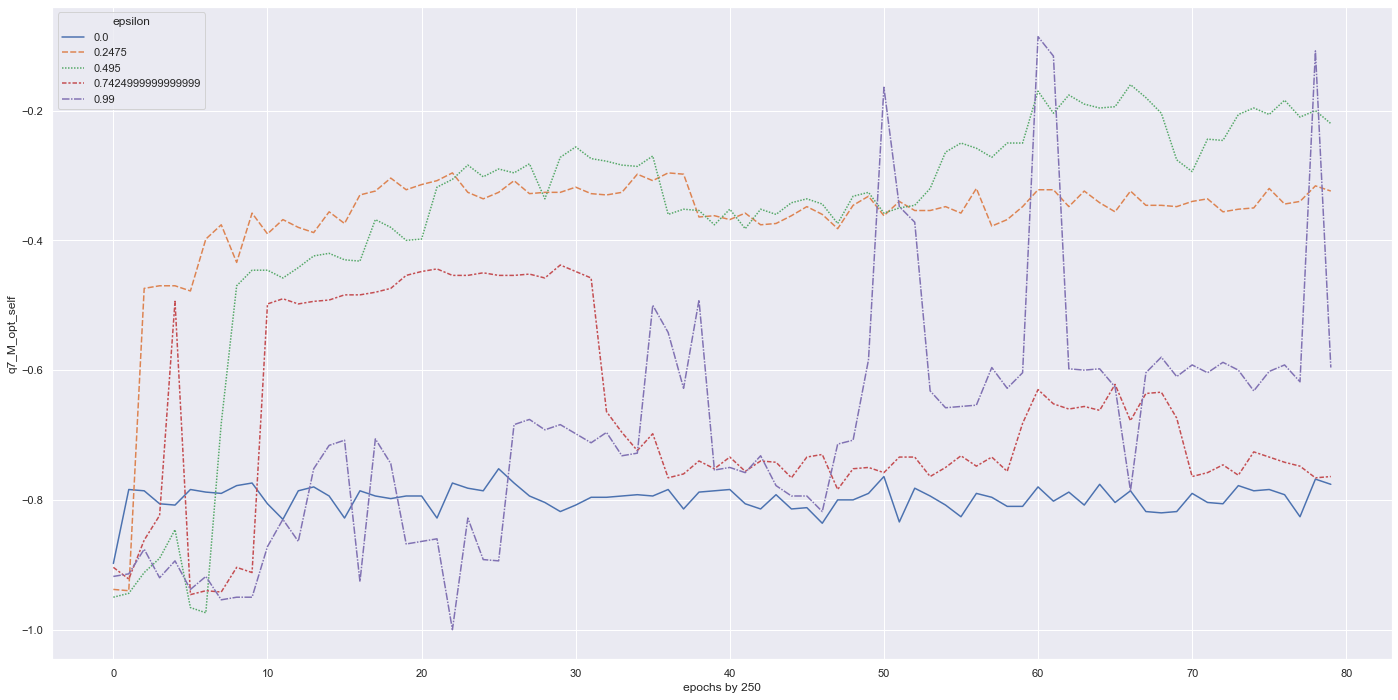

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

q7_M_opt_self_df = pd.DataFrame(q7_M_opt_self)
q7_M_opt_self_df.index.name = 'epochs by 250'
q7_M_opt_self_df.transpose().index.name = 'epsilon'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=q7_M_opt_self_df)
g.set_ylabel('q7_M_opt_self')

Text(0, 0.5, 'q7_M_opt_self')

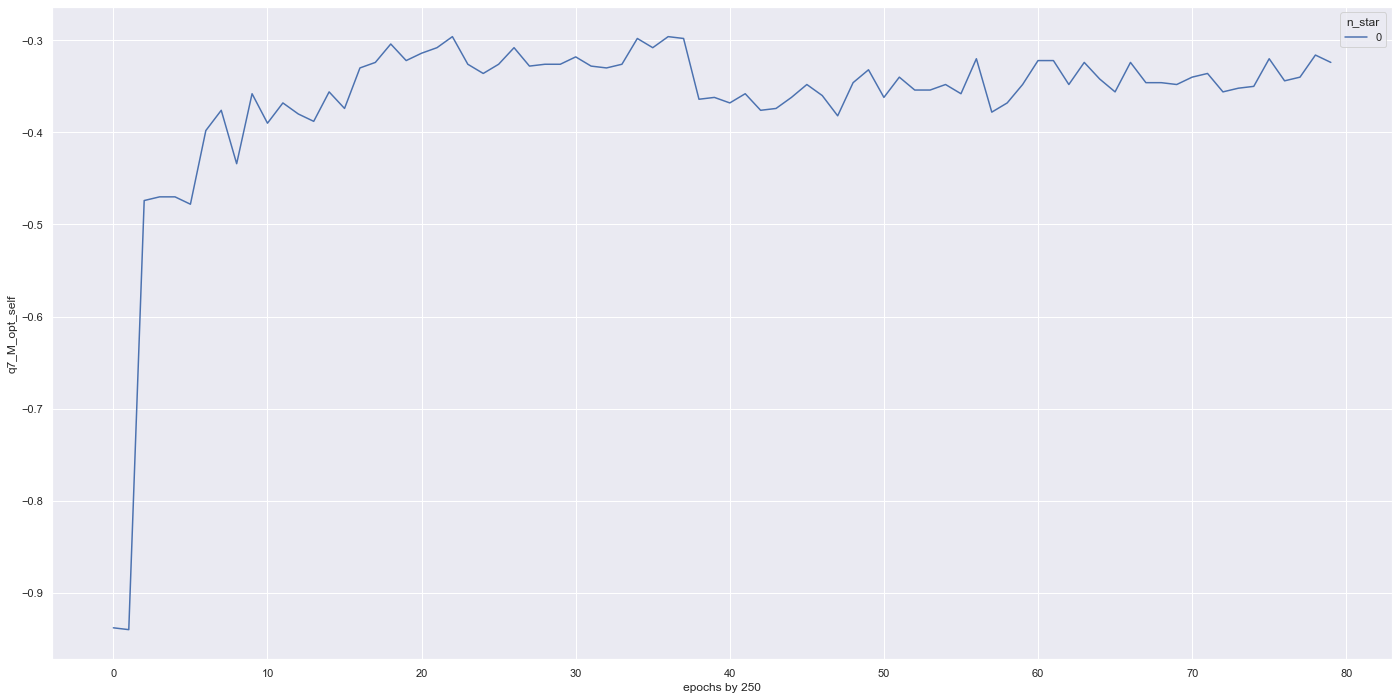

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

q7_M_opt_self_df = pd.DataFrame(q7_M_opt_self[q7_eps_selfs[1]])
q7_M_opt_self_df.index.name = 'epochs by 250'
q7_M_opt_self_df.transpose().index.name = 'n_star'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=q7_M_opt_self_df)
g.set_ylabel('q7_M_opt_self')

Text(0, 0.5, 'q7_M_rand_self')

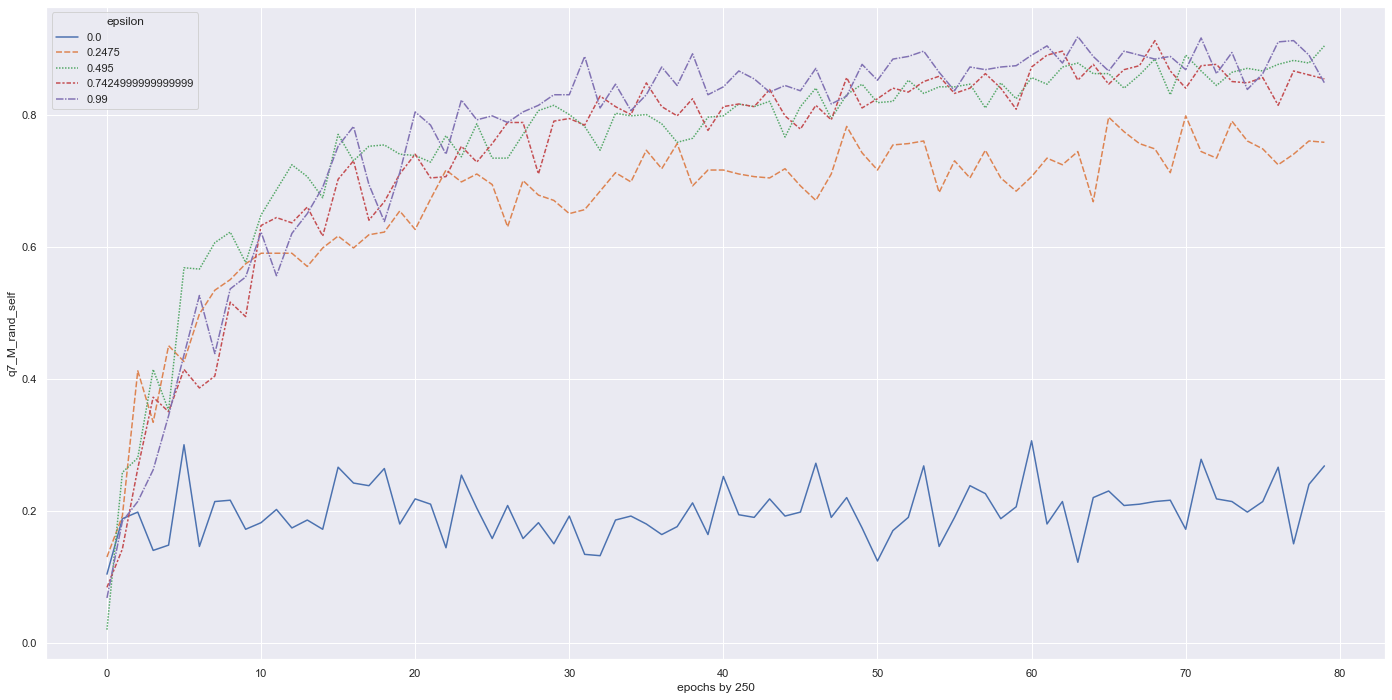

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

q7_M_rand_self_df = pd.DataFrame(q7_M_rand_self)
q7_M_rand_self_df.index.name = 'epochs by 250'
q7_M_rand_self_df.transpose().index.name = 'epsilon'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=q7_M_rand_self_df)
g.set_ylabel('q7_M_rand_self')

# Q7 (answer)
*Question 7. After every 250 games during training, compute the ‘test’ $M_{opt}$ and $M_{rand}$ for different
values of $\varepsilon \in [0, 1)$. Does the agent learn to play Tic Tac Toe? What is the effect of $\varepsilon$?
Expected answer: A figure showing $M_{opt}$ and $M_{rand}$ over time for different values of $\varepsilon \in [0, 1)$ (caption
length < 100 words).*


#### Does the agent learn to play Tic Tac Toe?
Indeed the agent does learn to play Tic Tac Toe as we can see from the improving performance against both $M_{opt}$ and $M_{rand}$. It never achieves perfect performance against $M_{opt}$ like previous models but it achieves pretty comparable performance against $M_{rand}$.


#### What is the effect of $\varepsilon$?
We observe similar effect to what we saw before with setting different $\varepsilon$ for optimal oponent: $\varepsilon \rightarrow 1$ defends quite poorly against optimal player while $\varepsilon=0$ never learns. This makes sense because $\varepsilon=0$ will not do any exploration and consequently, its Q-values will be 0 in most positions as it will never have seen them during training. Other values of $\varepsilon$ all achieve similar performance and differ mostly in the number of epochs it takes them to get to it, the optimal $\varepsilon$ seems to be around $\sim 0.5$ out of the values we tried.

**TODO:** The graph against M_opt looks a bit weird, why the large jumps?

# Q8 (code below)
For rest of this section, use $\epsilon(n)$ in Equation 1 with different values of $n^∗$ – instead of fixing $\epsilon$.
Question 8. After every 250 games during training, compute the ‘test’ $M_{opt}$ and $M_{rand}$ for your agents.
Does decreasing $\epsilon$ help training compared to having a fixed $\epsilon$? What is the effect of $n^∗$?
Expected answer: A figure showing $M_{opt}$ and $M_{rand}$ over time for different values of speeds of $n^∗$ (caption
length < 100 words).

In [28]:
q8_max_games = MAX_GAMES_DEFAULT
q8_n_stars =  np.geomspace(1, 40000, num=5) # Includes 1 and 40000
epoch_size = 250

q8_rewards_self_n_stars = {n_star_q8: {'our_player': [], 'opponent':[]} for n_star_q8 in q8_n_stars}
q8_M_opt_self_n_stars = {n_star_q8: [] for n_star_q8 in q8_n_stars}
q8_M_rand_self_n_stars = {n_star_q8: [] for n_star_q8 in q8_n_stars}

q8_min_epsilon = 0.1
q8_max_epsilon = 0.8
def q8_calc_epsilon_factory(n_star_q8, epoch_size, game_epoch):
        def _calc_epsilon(game_number_n):
            real_game_number = game_epoch*epoch_size + game_number_n
            return max(q8_min_epsilon, q8_max_epsilon*(1-(real_game_number/n_star_q8)))
        return _calc_epsilon

for n_star_q8 in q8_n_stars:
    q8_q_learnt_player = QLearntPlayer(_epsilon=q8_max_epsilon)
    print('Current n_star_q8 = {}'.format(n_star_q8))

    for game_epoch in range(q8_max_games//epoch_size):
        q8_calc_epsilon = q8_calc_epsilon_factory(n_star_q8=n_star_q8, epoch_size=epoch_size, game_epoch=game_epoch)
        if game_epoch % 20 == 0:
            print('Game ', game_epoch*epoch_size, ' begins.')

        # Run 250 games with updating Q-vals and observe reward (exec 8)
        run_rewards = run_n_games_against_self(_max_games_number=epoch_size, _our_player=q8_q_learnt_player, \
            _our_player_new_game_epsilon=q8_calc_epsilon, _update_q_values=True)
        q8_rewards_self_n_stars[n_star_q8]['our_player'] += run_rewards['our_player']
        q8_rewards_self_n_stars[n_star_q8]['opponent'] += run_rewards['opponent']

        # Run 500 games for q8_M_opt_self_n_stars calculation
        q8_M_opt_self_n_stars_rewards = run_n_games_against_opt(_max_games_number=500, _our_player=q8_q_learnt_player, _opponent_epsilon=0, \
            _our_player_new_game_epsilon=lambda game_number_n: 0, _update_q_values=False)
        q8_M_opt_self_n_stars[n_star_q8].append(np.average(q8_M_opt_self_n_stars_rewards))


        # Run 500 games for q8_M_rand_self_n_stars calculation
        q8_M_rand_self_n_stars_rewards = run_n_games_against_opt(_max_games_number=500, _our_player=q8_q_learnt_player, _opponent_epsilon=1, \
            _our_player_new_game_epsilon=lambda game_number_n: 0, _update_q_values=False)
        q8_M_rand_self_n_stars[n_star_q8].append(np.average(q8_M_rand_self_n_stars_rewards))



Current n_star_q8 = 1.0
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
Current n_star_q8 = 14.142135623730951
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
Current n_star_q8 = 200.00000000000003
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
Current n_star_q8 = 2828.4271247461907
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
Current n_star_q8 = 40000.0
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.


Text(0, 0.5, 'q8_M_rand_self_n_stars')

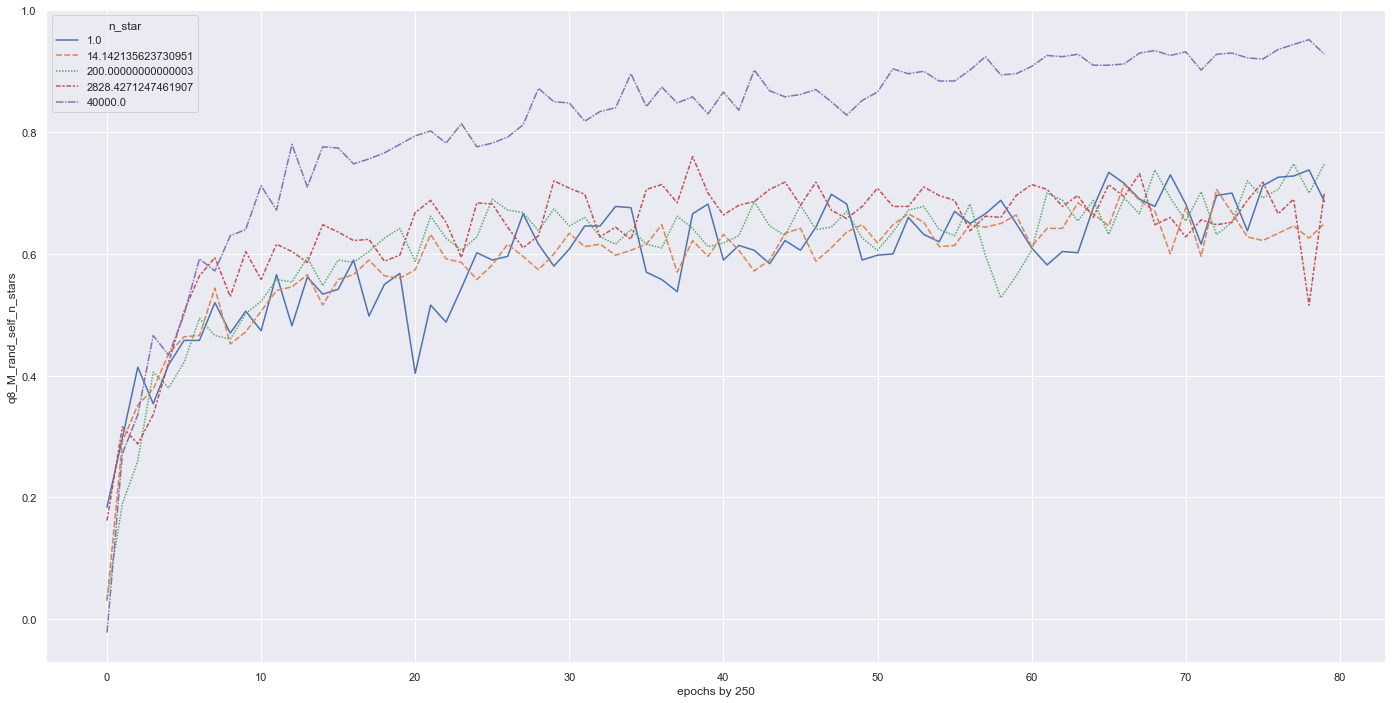

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

q8_M_rand_self_n_stars_df = pd.DataFrame(q8_M_rand_self_n_stars)
q8_M_rand_self_n_stars_df.index.name = 'epochs by 250'
q8_M_rand_self_n_stars_df.transpose().index.name = 'n_star'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=q8_M_rand_self_n_stars_df)
g.set_ylabel('q8_M_rand_self_n_stars')

Text(0, 0.5, 'q8_M_opt_self_n_stars')

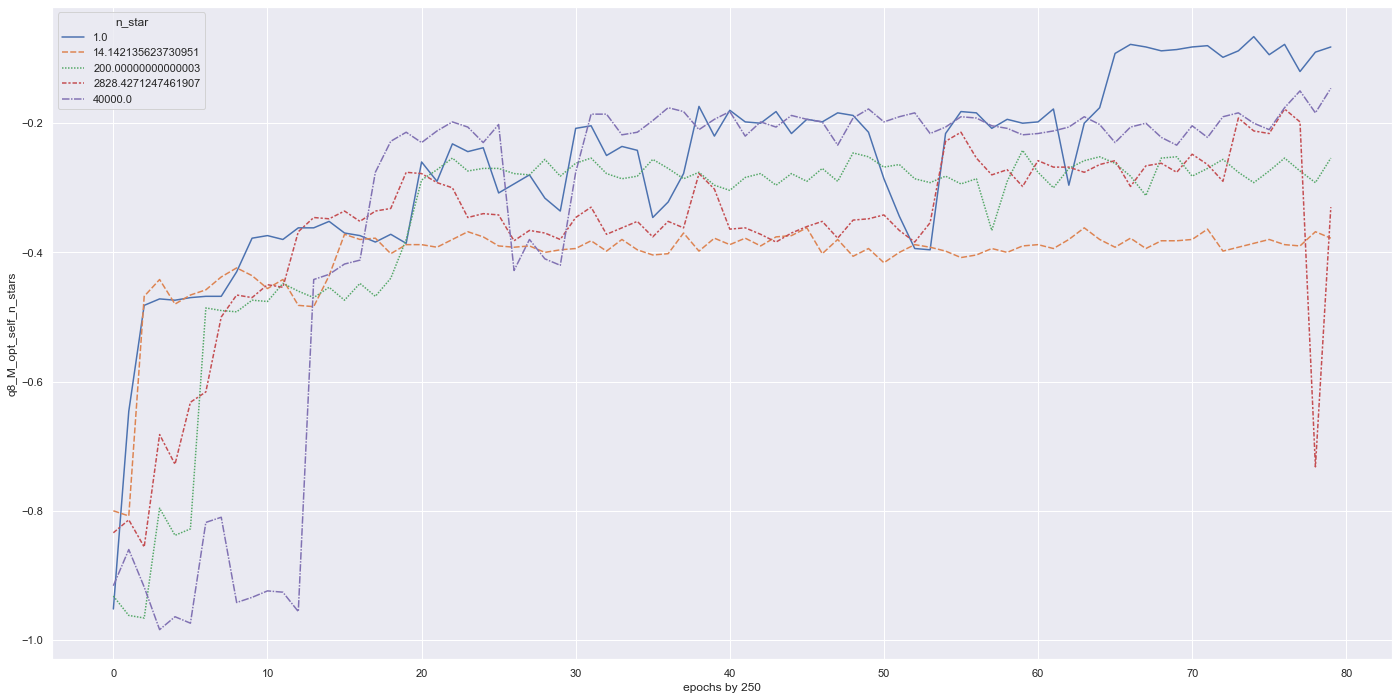

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

q8_M_opt_self_n_stars_df = pd.DataFrame(q8_M_opt_self_n_stars)
q8_M_opt_self_n_stars_df.index.name = 'epochs by 250'
q8_M_opt_self_n_stars_df.transpose().index.name = 'n_star'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=q8_M_opt_self_n_stars_df)
g.set_ylabel('q8_M_opt_self_n_stars')

# Q8 (answer)
For rest of this section, use $\varepsilon(n)$ in Equation 1 with different values of $n^∗$ – instead of fixing $\varepsilon$.
Question 8. After every 250 games during training, compute the ‘test’ $M_{opt}$ and $M_{rand}$ for your agents.
Does decreasing $\varepsilon$ help training compared to having a fixed $\varepsilon$? What is the effect of $n^∗$?
Expected answer: A figure showing $M_{opt}$ and $M_{rand}$ over time for different values of speeds of $n^∗$ (caption
length < 100 words).

#### Does decreasing $\varepsilon$ help training compared to having a fixed $\varepsilon$? What is the effect of $n^∗$?
Here, decreasing epsilon seems to help massively especially when compared with its effect without left-play. Interestingly, it seems the higher $n^∗$ the better (unlike before). This makes sense because $n^∗=40000$ means that $\varepsilon$ will spend a large chunk of its time around $\sim 0.5$ which we discovered as the best value for a fixed epsilon in the previous step. Here, a variable $\varepsilon$ seems to perform even better, especially against $M_{opt}$.


**TODO:** A little strange that we get optimal perf against M_opt but then we lose it.

In [31]:
print('Best M_opt:', q8_M_opt_self_n_stars_df.max())
print('\n')
print('Best M_rand', q8_M_rand_self_n_stars_df.max())

Best M_opt: n_star
1.000000       -0.066
14.142136      -0.362
200.000000     -0.242
2828.427125    -0.178
40000.000000   -0.146
dtype: float64


Best M_rand n_star
1.000000        0.738
14.142136       0.714
200.000000      0.748
2828.427125     0.760
40000.000000    0.952
dtype: float64


# Q9
*Question 9. What are the highest values of $M_{opt}$ and $M_{rand}$ that you could achieve after playing 20’000 games?*

The best value for $M_{opt}$ was **0** achieved by $n^*=40000$ and the best value for $M_{rand}$ was **0.95** achieved again by $n^*=40000$.

# Q10
*Question 10. For three board arrangements (i.e. states s), visualize Q-values of available actions (e.g.
using heat maps). Does the result make sense? Did the agent learn the game well?
Expected answer: A figure with 3 subplots of 3 different states with Q-values shown at available actions
(caption length < 200 words).*

In [32]:
positions_to_display = random.sample(list(q8_q_learnt_player._Q_values.items()), 3)
positions_to_display = [(grid_to_string(k), v) for (k,v) in positions_to_display]
positions_to_display[0][1]

{(0, 1): 0, (2, 0): 0.0, (2, 1): 0, (2, 2): 0}

|- O -|
|- X O|
|- X X|




<AxesSubplot:>

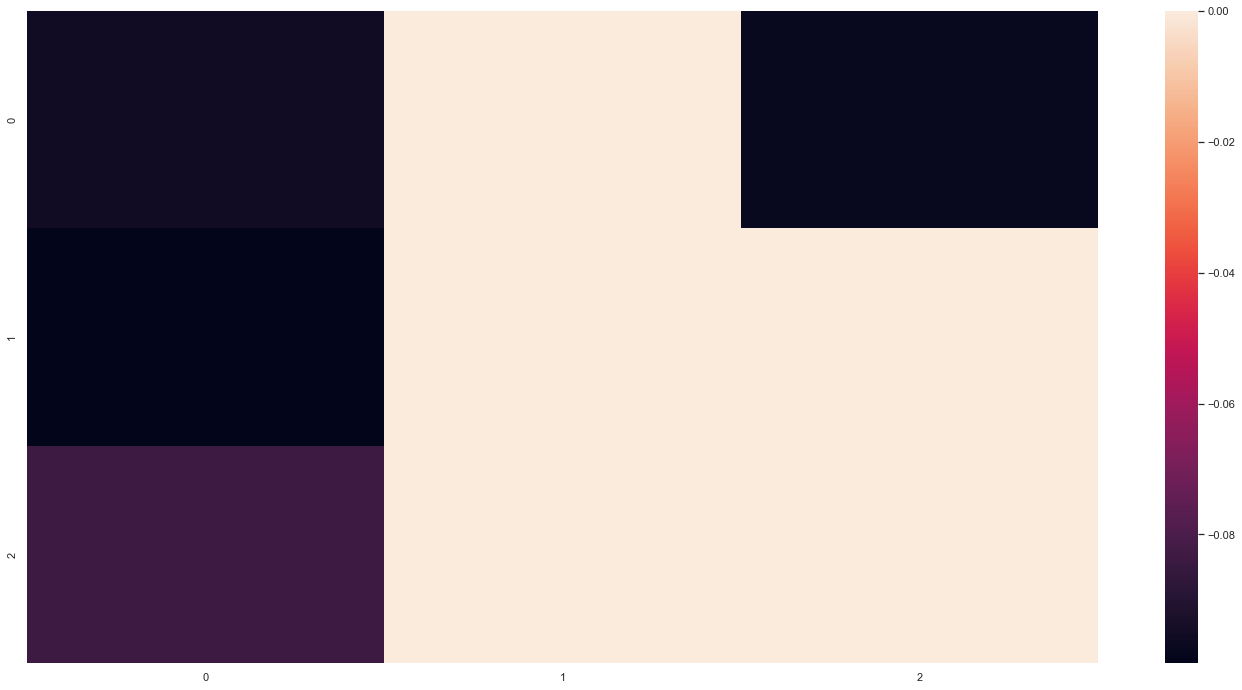

In [33]:
import seaborn as sns
heatmap_data = []
current_pos = positions_to_display[1]
for i in range(9):
    pos = (int(i/3), i % 3)
    if current_pos[1].get(pos):
        heatmap_data.append(current_pos[1].get(pos))
    else:
        heatmap_data.append(0)
print(current_pos[0])
sns.heatmap(np.array(heatmap_data).reshape((3,3)))

|- - X|
|X - X|
|O O O|




<AxesSubplot:>

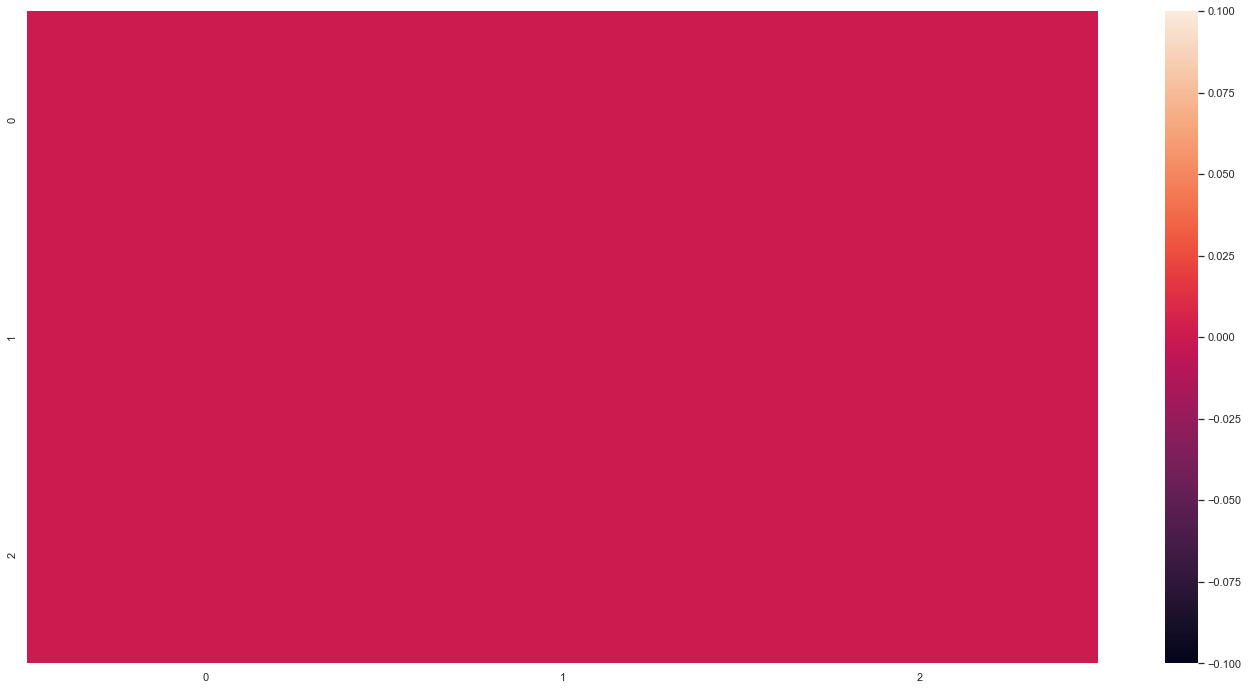

In [34]:
import seaborn as sns
heatmap_data = []
current_pos = positions_to_display[2]
for i in range(9):
    pos = (int(i/3), i % 3)
    if current_pos[1].get(pos):
        heatmap_data.append(current_pos[1].get(pos))
    else:
        heatmap_data.append(0)
print(current_pos[0])
sns.heatmap(np.array(heatmap_data).reshape((3,3)))

# Q10 (answer)
#### Does the result make sense? Did the agent learn the game well?
We sampled 3 randoms states from the best agent taught by selfplay ($n^* = 40000$). The heatmaps show the agent has indeed learnt to play the game well – the best move always has the highest Q-value and winning moves have Q-values above 0 while losing moves have Q-values below 0.

# 3 Deep Q-Learning
As our 2nd algorithm, we use Deep Q-Learning (DQN) combined with $\epsilon$-greedy policy. You can watch
again Part 1 of Deep Reinforcement Learning Lecture 1 for an introduction to DQN and Part 1 of
Deep Reinforcement Learning Lecture 2 (in particular slide 8) for more details. The idea in DQN is
to approximate Q-values by a neural network instead of a look-up table as in Tabular Q-learning. For
implementation, you can use ideas from the DQN tutorials of Keras and PyTorch.

# 3.2 Learning from experts
Implement the DQN algorithm. To check the algorithm, run a DQN agent with a fixed and arbitrary
$\epsilon \in [0,1)$ against Opt(0.5) for 20’000 games – switch the 1st player after every game.

## Question 11
*Plot average reward and average training loss for every 250 games during training. Does
the loss decrease? Does the agent learn to play Tic Tac Toe?
Expected answer: A figure with two subplots (caption length $<$ 50 words). Specify your choice of $\epsilon$.*

**Answer:** We use $\epsilon = 0.05$ as that is the value that Mnih at el (2015) use.

In [35]:
import torch
from torch import nn
from torch.nn import functional as F
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def state_to_torch(game_state: np.ndarray):
    torch_no_batch =  torch.cat((torch.from_numpy((game_state == 1).astype(np.float32)).view(1,3,3,1), torch.from_numpy((game_state == -1).astype(np.float32)).view(1,3,3,1)), dim=3).to(device)
    return torch_no_batch

def game_state_converts_to_pytorch_correctly():
    game_state = np.array([ [ 1.,  1.,  1.], \
                            [ 1.,  0., -1.], \
                            [-1., -1.,  1.]])
    torch_repre = state_to_torch(game_state).view(3,3,2)
    expected_our_positions = torch.from_numpy((game_state==1).astype(int))
    torch_repre_our_positions = torch_repre[:,:,0]
    assert (expected_our_positions == torch_repre_our_positions).all()
    expected_opponent_positions = torch.from_numpy((game_state==-1).astype(int))
    torch_repre_opponent_positions = torch_repre[:,:,1]
    assert (expected_opponent_positions == torch_repre_opponent_positions).all()
    return True

assert game_state_converts_to_pytorch_correctly()

In [36]:
# This cell's code is largely taken from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html?highlight=huber

from collections import namedtuple, deque
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        # " Once a bounded length deque is full, when new items are added, a corresponding number
        # of items are discarded from the opposite end. " (https://docs.python.org/3/library/collections.html#collections.deque)
        self.memory = deque([],maxlen=capacity)

    def push(self, _new_memory: Transition):
        """Save a transition"""
        self.memory.append(_new_memory)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [37]:
class DQNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net =  nn.Sequential(
            nn.Linear(18, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 9))

    def forward(self, inp):
        batch_size = inp.size(0)
        input_in_1D = inp.view(batch_size,-1)
        output = self.net(input_in_1D)
        return output

summary(DQNet().to(device), input_size=(3,3,2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           2,432
              ReLU-2                  [-1, 128]               0
            Linear-3                  [-1, 128]          16,512
              ReLU-4                  [-1, 128]               0
            Linear-5                    [-1, 9]           1,161
Total params: 20,105
Trainable params: 20,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.08
Estimated Total Size (MB): 0.08
----------------------------------------------------------------


In [38]:
eg_tensor = torch.tensor([0.1,0.2]  +5*[0] + [-0.3,-0.4]).view(9,-1)
eg_tensor.numpy().reshape(9)

array([ 0.1,  0.2,  0. ,  0. ,  0. ,  0. ,  0. , -0.3, -0.4],
      dtype=float32)

In [39]:
class DQN_Player(BasePlayer):
    INDEX_TO_POSITIONS = BasePlayer().get_empty_positions(TictactoeEnv().grid)
    POSITIONS_TO_INDEX = {position: index for index, position in enumerate(INDEX_TO_POSITIONS)}
    LEARNING_RATE = 5 * 10e-4 # Given in the instructions PDF
    DISCOUNT_RATE_GAMMA = 0.99
    DEFAULT_BATCH_SIZE = 64
    DEFAULT_BUFFER_SIZE = 10_000
    TARGET_NEW_UPDATE_FREQUENCY = 500

    def __init__(self, _epsilon: float, _batch_size = DEFAULT_BATCH_SIZE, _replay_buffer_size = DEFAULT_BUFFER_SIZE):
        self._policy_net = DQNet()
        self._target_net = DQNet()
        self._target_net.load_state_dict(self._policy_net.state_dict())
        self._replay_buffer = ReplayMemory(_replay_buffer_size)
        self._optimizer = torch.optim.Adam(self._policy_net.parameters(), lr=DQN_Player.LEARNING_RATE)
        self._criterion = nn.SmoothL1Loss() # "When delta is set to 1, this loss is equivalent to SmoothL1Loss." (PyTorch HuberLoss documentation)
        self._epsilon = _epsilon
        self._latest_memory = {'state': None, 'action': None, 'next_state': None, 'reward': None}
        self._player = None # 'X' or 'O'
        self._game_count = 0
        self._batch_size = _batch_size
        self._replay_buffer_size = _replay_buffer_size

    def prepare_new_game_(self, _player):
        # These assertions make sense when we are learning but they get broken
        # during M_opt and M_rand calculations
        # assert self._latest_memory['state'] is None
        # assert self._latest_memory['action'] is None
        # assert self._latest_memory['next_state'] is None
        # assert self._latest_memory['reward'] is None
        assert _player == 'X' or _player == 'O'
        self._player = _player
        self._game_count += 1
        return self

    def get_q_values_from_network(self, _torch_grid):
        with torch.no_grad():
            net_q_vals = self._policy_net(_torch_grid)
            # This is slow and it would be easier to just take the max but I implement it like this for easier debugging
            # Also this is consistent with previous Q-value representation, which will allow us to reuse debugging functions
            numpy_q_vals = net_q_vals.numpy().reshape(9)
            dict_q_vals = {move: numpy_q_vals[move_index] for (move_index, move) in enumerate(DQN_Player.INDEX_TO_POSITIONS)} 
            return dict_q_vals

    def get_max_val_action(self, _q_values):
        return max(_q_values, key=_q_values.get)

    def choose_move_(self, _grid):
        torch_grid = state_to_torch(_grid)

        random_sample = random.random()
        play_best_move = random_sample >= self._epsilon
        if play_best_move:
            q_values = self.get_q_values_from_network(_torch_grid=torch_grid)
            chosen_move = self.get_max_val_action(_q_values=q_values)
        else:
            possible_moves = self.get_empty_positions(_grid)
            chosen_move = random.choice(possible_moves)

        # These assertions make sense when we are learning but they get broken
        # during M_opt and M_rand calculations
        # assert self._latest_memory['state'] is None
        # assert self._latest_memory['action'] is None

        self._latest_memory['state'] = torch_grid
        self._latest_memory['action'] = torch.tensor([DQN_Player.POSITIONS_TO_INDEX[chosen_move]])

        if DEBUG:
            if not play_best_move:
                q_values = self.get_q_values_from_network(_torch_grid=torch_grid) # ensure q_values are defined
            print('-----------------------------------')
            print('Current position: ', '\n' + grid_to_string(_grid, False))
            print('Current Q-vals', q_values)
            print('Random sample ', random_sample, ' _epsilon ', self._epsilon, ' hence I chose ', \
                '*best*' if play_best_move else '*random*', ' move: ', chosen_move )
            print('-----------------------------------')

        return chosen_move

    def reset_latest_memory_(self):
        self._latest_memory['state'] = None
        self._latest_memory['action'] = None
        self._latest_memory['next_state'] = None
        self._latest_memory['reward'] = None

    def create_memory_(self, _next_state, _reward):
        # assert self._latest_memory['state'] is not None
        # assert self._latest_memory['action'] is not None
        # assert self._latest_memory['next_state'] is None
        # assert self._latest_memory['reward'] is None

        self._latest_memory['next_state'] = _next_state
        self._latest_memory['reward'] = torch.tensor([_reward])
        new_memory = Transition(**self._latest_memory)
        self._replay_buffer.push(new_memory)
        self.reset_latest_memory_()

    def learn_from_memories_(self):
        if len(self._replay_buffer) < self._batch_size:
            return
        replay_memories = self._replay_buffer.sample(self._batch_size)

        # next few lines inspired by https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html#training-loop
        batch = Transition(*zip(*replay_memories))
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        non_final_mask = torch.tensor(tuple(map(lambda s: s != '', \
            batch.next_state)), device=device, dtype=torch.bool)

        non_final_next_states = state_batch[non_final_mask]

        _temp = self._policy_net(state_batch)





        pre_move_q_vals = _temp.gather(1, action_batch.view(action_batch.size(0),1))
        # print(action_batch)



        post_move_q_vals = torch.zeros(self._batch_size)

        # Don't call net if there are no non_final states in the batch
        if non_final_next_states.size(0) > 0:
            post_move_q_vals[non_final_mask] = self._target_net(non_final_next_states).max(1)[0].detach()
        expected_post_move_q_vals = (post_move_q_vals * self.DISCOUNT_RATE_GAMMA) + reward_batch

        # print(pre_move_q_vals.shape)
        loss = self._criterion(pre_move_q_vals, expected_post_move_q_vals.unsqueeze(1))
        self._optimizer.zero_grad()
        loss.backward()
        self._optimizer.step()

        if self._game_count % self.TARGET_NEW_UPDATE_FREQUENCY == 0:
            self._target_net.load_state_dict(self._policy_net.state_dict())

    def update_q_values_(self, new_grid, game_over, _reward):
        """
        same signature and name as in QLearntPlayer in order to keep the same interface,
        even though another name would perhaps be more appropriate here
        """
        # If the next state is a final state, save '' instead: we need to signify the state is final
        # as the target network cannot predict the q-value of best action there since in a final state,
        # no action can be taken (we just give it Q-val of 0 instead)
        next_state = state_to_torch(new_grid) if not game_over else ''
        self.create_memory_(_next_state=next_state, _reward=_reward)
        self.learn_from_memories_()


Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
won games per agent 6746
Our agent won 6746 times


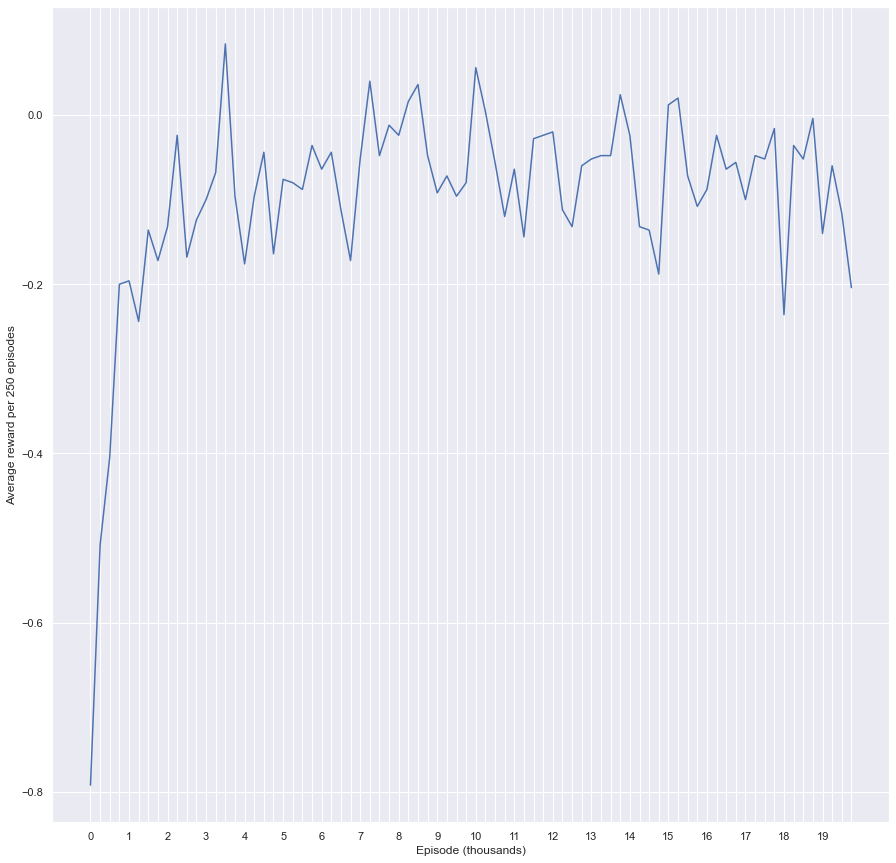

In [46]:
import matplotlib.pyplot as plt

q11_epsilon = 0.1 # Chosen because they use this in q2 so this will allow us to nicely compare

q11_max_games = MAX_GAMES_DEFAULT
q11_dqn_player = DQN_Player(_epsilon=q11_epsilon)
q11_epoch_size = 250
q11_rewards = []
q11_avgs = []
q11_M_opt = []
q11_M_rand = []
q11_total_wins = 0

for game_epoch in range(q11_max_games//q11_epoch_size):
    if game_epoch % 20 == 0:
        print('Game ', game_epoch*q11_epoch_size, ' begins.')

    # Run 250 games with updating Q-vals and observe reward (exec 2)
    q11_run_rewards = run_n_games_against_opt(_max_games_number=250, _our_player=q11_dqn_player, _opponent_epsilon=0.5, \
            _our_player_new_game_epsilon=lambda game_number_n: q11_epsilon, _update_q_values=True, _throw_error_on_illegal_moves=False)
    q11_avgs.append(np.average(q11_run_rewards))
    q11_rewards += q11_run_rewards
    q11_total_wins += sum(1 if rew ==1 else 0 for rew in q11_run_rewards)

    with torch.no_grad():
        # Run 500 games for M_opt calculation
        q11_M_opt_rewards = run_n_games_against_opt(_max_games_number=500, _our_player=q11_dqn_player, _opponent_epsilon=0, \
            _our_player_new_game_epsilon=lambda game_number_n: 0, _update_q_values=False, _throw_error_on_illegal_moves=False)
        q11_M_opt.append(np.average(q11_M_opt_rewards))


        # Run 500 games for M_rand calculation
        M_rand_rewards = run_n_games_against_opt(_max_games_number=500, _our_player=q11_dqn_player, _opponent_epsilon=1, \
            _our_player_new_game_epsilon=lambda game_number_n: 0, _update_q_values=False, _throw_error_on_illegal_moves=False)
        q11_M_rand.append(np.average(M_rand_rewards))

print('won games per agent', q11_total_wins)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print('Our agent won {} times'.format(q11_total_wins))
plt.figure(figsize=(15,15))
ax = plt.plot(q11_avgs)
plt.xticks(ticks=range(len(q11_avgs)), labels=[str(x*250 // 1000) if x*250 % 1000 == 0 else '' for x in range(len(q11_avgs))])
plt.ylabel('Average reward per 250 episodes')
plt.xlabel('Episode (thousands)')
plt.show()


Text(0, 0.5, 'M_opt')

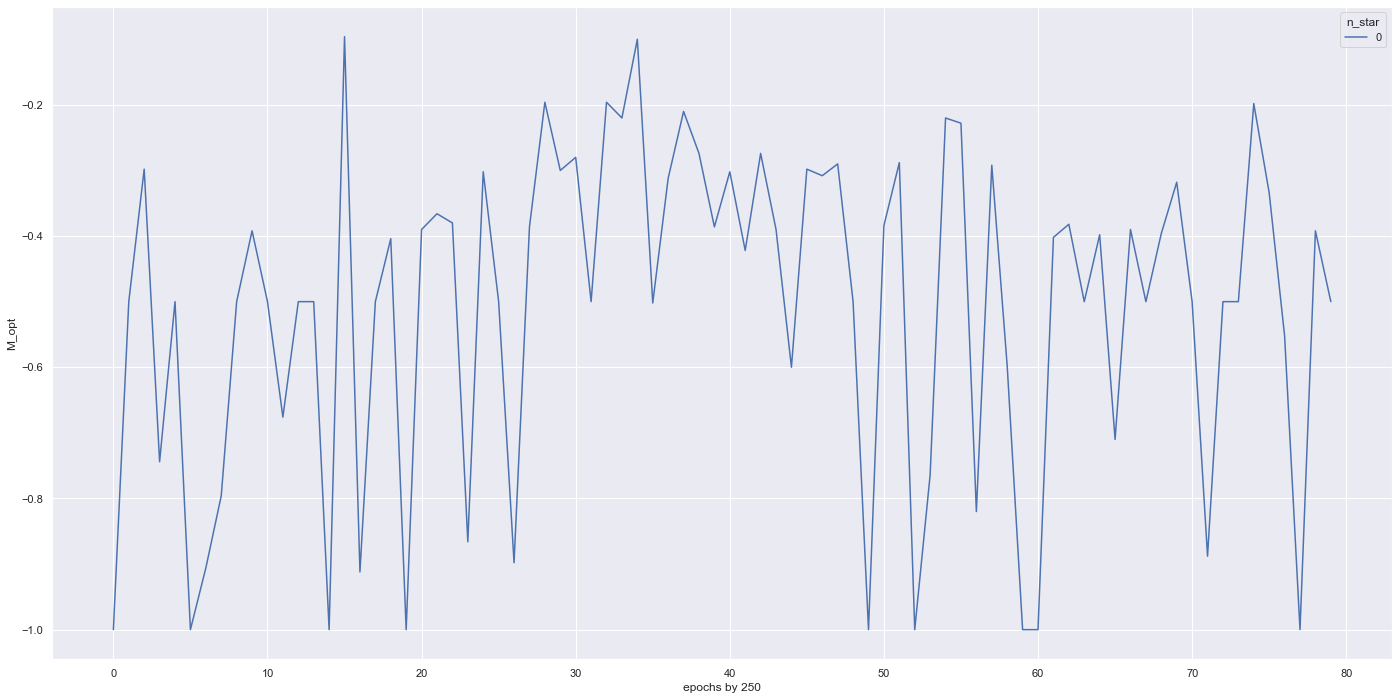

In [47]:
q11_M_opt_df = pd.DataFrame(q11_M_opt)
q11_M_opt_df.index.name = 'epochs by 250'
q11_M_opt_df.transpose().index.name = 'n_star'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=q11_M_opt_df)
g.set_ylabel('M_opt')

Text(0, 0.5, 'q11_M_rand')

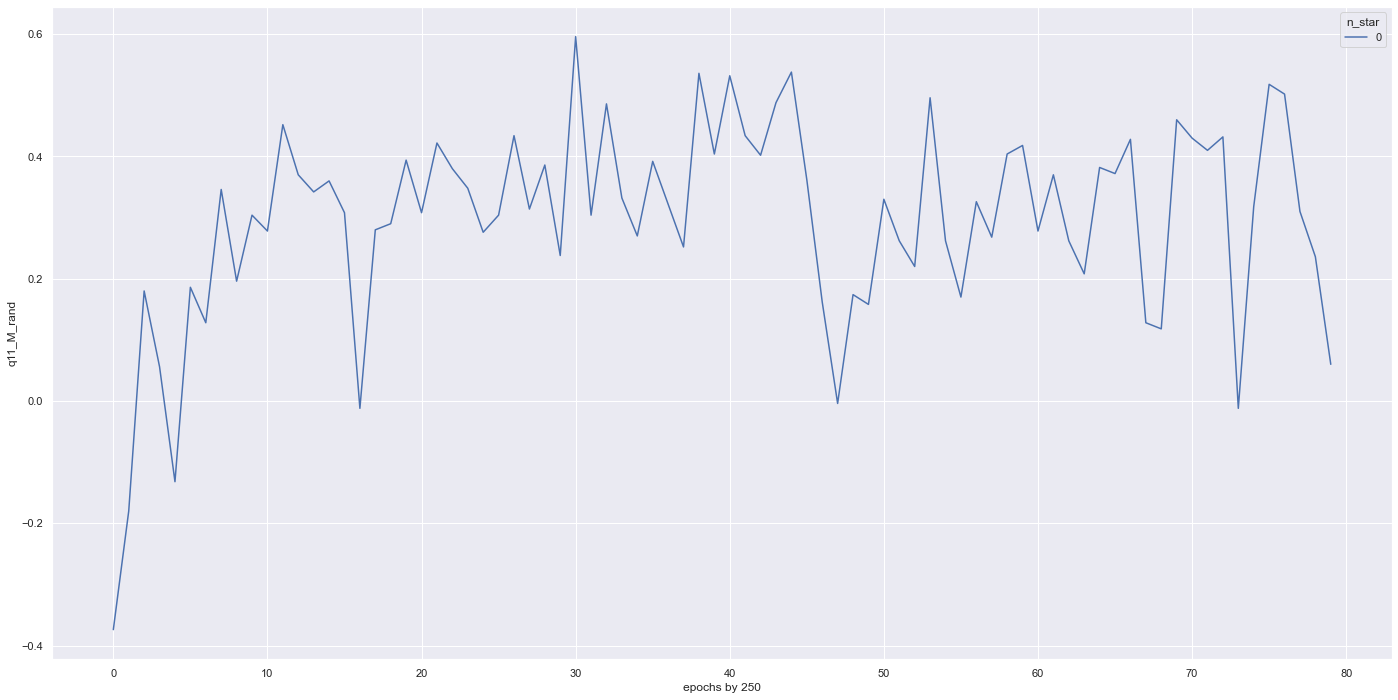

In [48]:
q11_M_rand_df = pd.DataFrame(q11_M_rand)
q11_M_rand_df.index.name = 'epochs by 250'
q11_M_rand_df.transpose().index.name = 'n_star'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=q11_M_rand_df)
g.set_ylabel('q11_M_rand')

# Q 12

Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
won games per agent 1918
Our agent won 1918 times


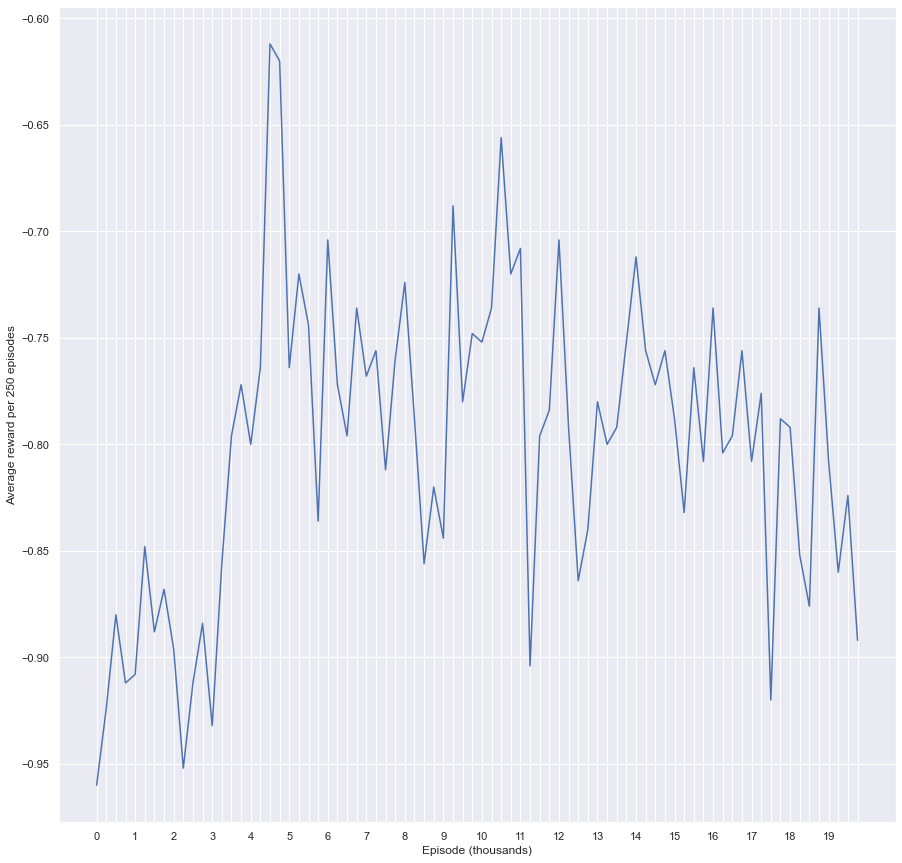

In [49]:
import matplotlib.pyplot as plt

q12_epsilon = 0.1 # Chosen because they use this in q2 so this will allow us to nicely compare

q12_max_games = MAX_GAMES_DEFAULT
q12_dqn_player = DQN_Player(_epsilon=q12_epsilon, _batch_size=1, _replay_buffer_size=1)
q12_epoch_size = 250
q12_rewards = []
q12_avgs = []
q12_M_opt = []
q12_M_rand = []
q12_total_wins = 0

for game_epoch in range(q12_max_games//q12_epoch_size):
    if game_epoch % 20 == 0:
        print('Game ', game_epoch*q12_epoch_size, ' begins.')

    # Run 250 games with updating Q-vals and observe reward (exec 2)
    q12_run_rewards = run_n_games_against_opt(_max_games_number=250, _our_player=q12_dqn_player, _opponent_epsilon=0.5, \
            _our_player_new_game_epsilon=lambda game_number_n: q12_epsilon, _update_q_values=True, _throw_error_on_illegal_moves=False)
    q12_avgs.append(np.average(q12_run_rewards))
    q12_rewards += q12_run_rewards
    q12_total_wins += sum(1 if rew ==1 else 0 for rew in q12_run_rewards)

    with torch.no_grad():
        # Run 500 games for M_opt calculation
        q12_M_opt_rewards = run_n_games_against_opt(_max_games_number=500, _our_player=q12_dqn_player, _opponent_epsilon=0, \
            _our_player_new_game_epsilon=lambda game_number_n: 0, _update_q_values=False, _throw_error_on_illegal_moves=False)
        q12_M_opt.append(np.average(q12_M_opt_rewards))


        # Run 500 games for M_rand calculation
        M_rand_rewards = run_n_games_against_opt(_max_games_number=500, _our_player=q12_dqn_player, _opponent_epsilon=1, \
            _our_player_new_game_epsilon=lambda game_number_n: 0, _update_q_values=False, _throw_error_on_illegal_moves=False)
        q12_M_rand.append(np.average(M_rand_rewards))

print('won games per agent', q12_total_wins)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print('Our agent won {} times'.format(q12_total_wins))
plt.figure(figsize=(15,15))
ax = plt.plot(q12_avgs)
plt.xticks(ticks=range(len(q12_avgs)), labels=[str(x*250 // 1000) if x*250 % 1000 == 0 else '' for x in range(len(q12_avgs))])
plt.ylabel('Average reward per 250 episodes')
plt.xlabel('Episode (thousands)')
plt.show()


Text(0, 0.5, 'M_opt')

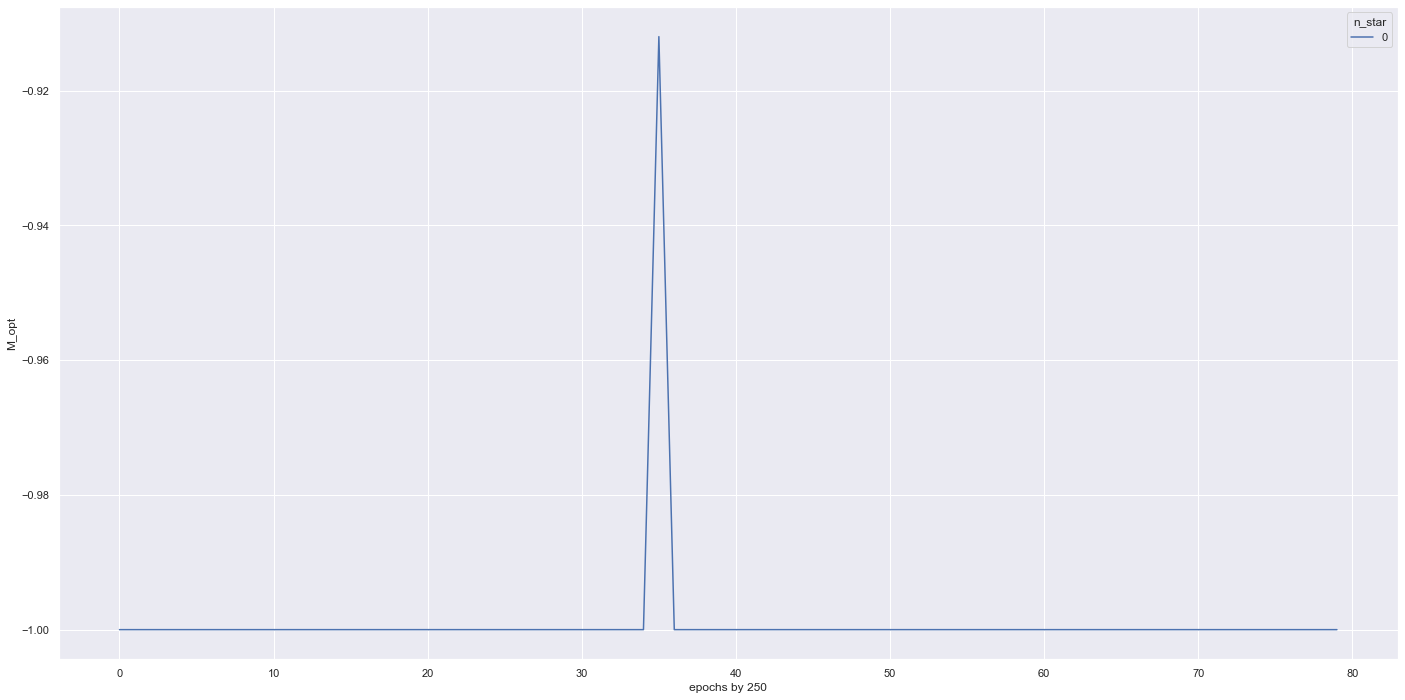

In [50]:
q12_M_opt_df = pd.DataFrame(q12_M_opt)
q12_M_opt_df.index.name = 'epochs by 250'
q12_M_opt_df.transpose().index.name = 'n_star'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=q12_M_opt_df)
g.set_ylabel('M_opt')

Text(0, 0.5, 'q12_M_rand')

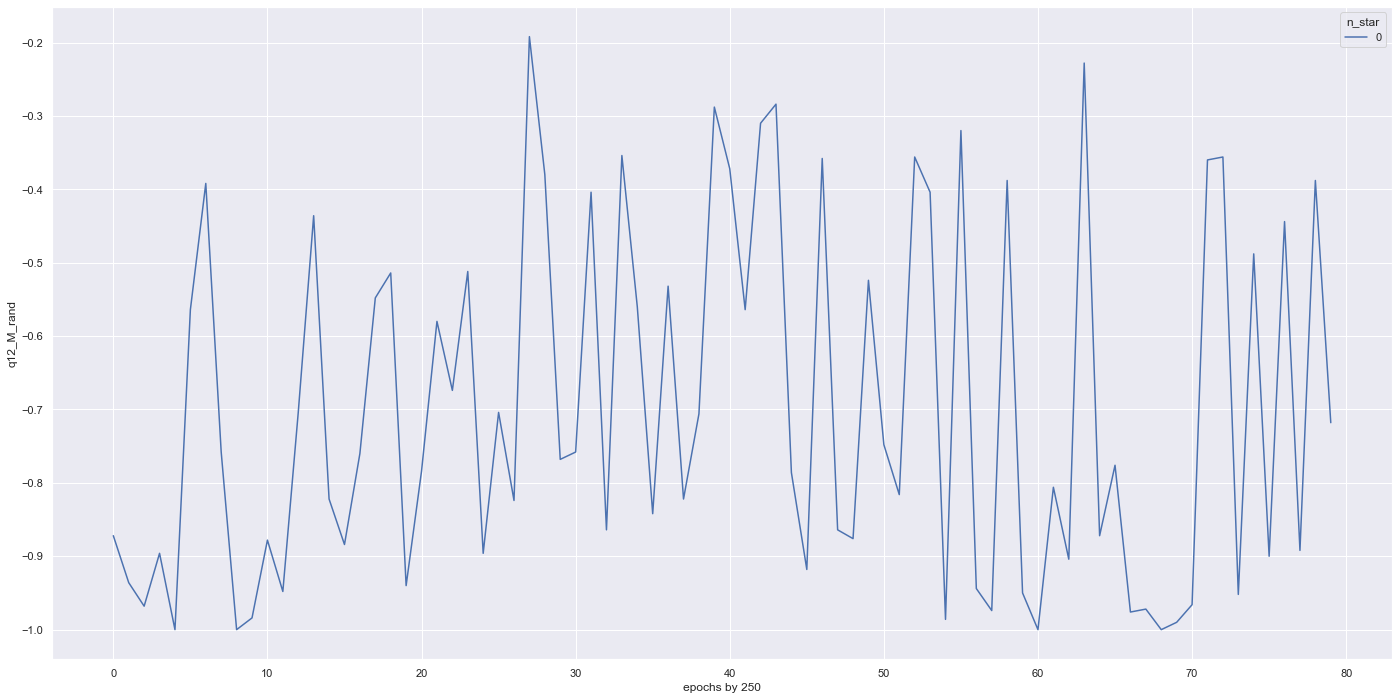

In [51]:
q12_M_rand_df = pd.DataFrame(q12_M_rand)
q12_M_rand_df.index.name = 'epochs by 250'
q12_M_rand_df.transpose().index.name = 'n_star'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=q12_M_rand_df)
g.set_ylabel('q12_M_rand')